In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import make_pipeline

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Import Dataset

In [3]:
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/Data Science/1. Telco Customer Churn/Data/TelcoChurn_prep.csv")

pd.set_option("display.max_columns",None)

df

Mounted at /content/drive


customerID    tenure  MonthlyCharges  TotalCharges Churn  Gender Male  \
0     7590-VHVEG -1.280248       -1.161694     -0.994194    No            0   
1     5575-GNVDE  0.064303       -0.260878     -0.173740    No            1   
2     3668-QPYBK -1.239504       -0.363923     -0.959649   Yes            1   
3     7795-CFOCW  0.512486       -0.747850     -0.195248    No            1   
4     9237-HQITU -1.239504        0.196178     -0.940457   Yes            0   
...          ...       ...             ...           ...   ...          ...   
7027  6840-RESVB -0.343137        0.664868     -0.129180    No            1   
7028  2234-XADUH  1.612573        1.276493      2.241056    No            0   
7029  4801-JZAZL -0.872808       -1.170004     -0.854514    No            0   
7030  8361-LTMKD -1.158016        0.319168     -0.872095   Yes            1   
7031  3186-AJIEK  1.368109        1.357932      2.012344    No            1   

      Is SeniorCitizen  Have Partner  Have Dependents  Have PhoneService  \
0                    0             1                0                  0   
1                    0             0                0                  1   
2                    0             0                0                  1   
3                    0             0                0                  0   
4                    0             0                0                  1   
...                ...           ...              ...                ...   
7027                 0             1                1                  1   
7028                 0             1                1                  1   
7029                 0             1                1                  0   
7030                 1             1                0                  1   
7031                 0             0                0                  1   

      Not Have MultipleLines  Have MultipleLines  \
0                          0                   0   
1                          1                   0   
2                          1                   0   
3                          0                   0   
4                          1                   0   
...                      ...                 ...   
7027                       0                   1   
7028                       0                   1   
7029                       0                   0   
7030                       0                   1   
7031                       1                   0   

      Using DSL as InternetService  Using Fiber optic as InternetService  \
0                                1                                     0   
1                                1                                     0   
2                                1                                     0   
3                                1                                     0   
4                                0                                     1   
...                            ...                                   ...   
7027                             1                                     0   
7028                             0                                     1   
7029                             1                                     0   
7030                             0                                     1   
7031                             0                                     1   

      Not Have OnlineSecurity  Have OnlineSecurity  Not Have OnlineBackup  \
0                           1                    0                      0   
1                           0                    1                      1   
2                           0                    1                      0   
3                           0                    1                      1   
4                           1                    0                      1   
...                       ...                  ...                    ...   
7027                        0                    1                 

# Drop CustomerID

In [4]:
df = df.drop(["customerID"],axis=1)

# Ubah Churn

In [5]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Train Test Split

In [6]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balancing imbalace data

KNN adalah model yang sensitif terhadap imbalance dataset, dikarenakan sifatnya yang melihat tetangga terdekat, mari kita analisi terlebih dahulu sebelum memastikan apakah kita akan melakukan handling imbalance dataset atau tidak

analisi akan dilakukan dengan Tolok ukur metode Over-sampling antara lain no sampling, random over sampling, ADSYN, dan SMOTE yang sudah dilakukan StratifiedKFold yang memastikan bahwa proporsi kelas target dalam setiap fold sama dengan proporsi kelas target dalam keseluruhan dataset ini.

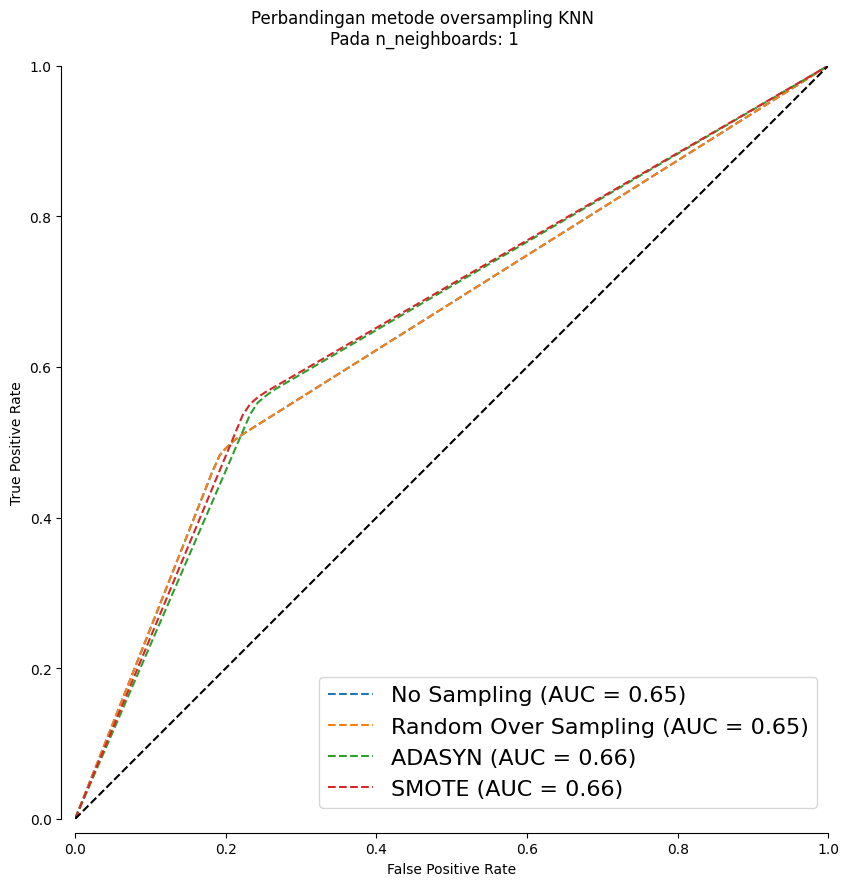

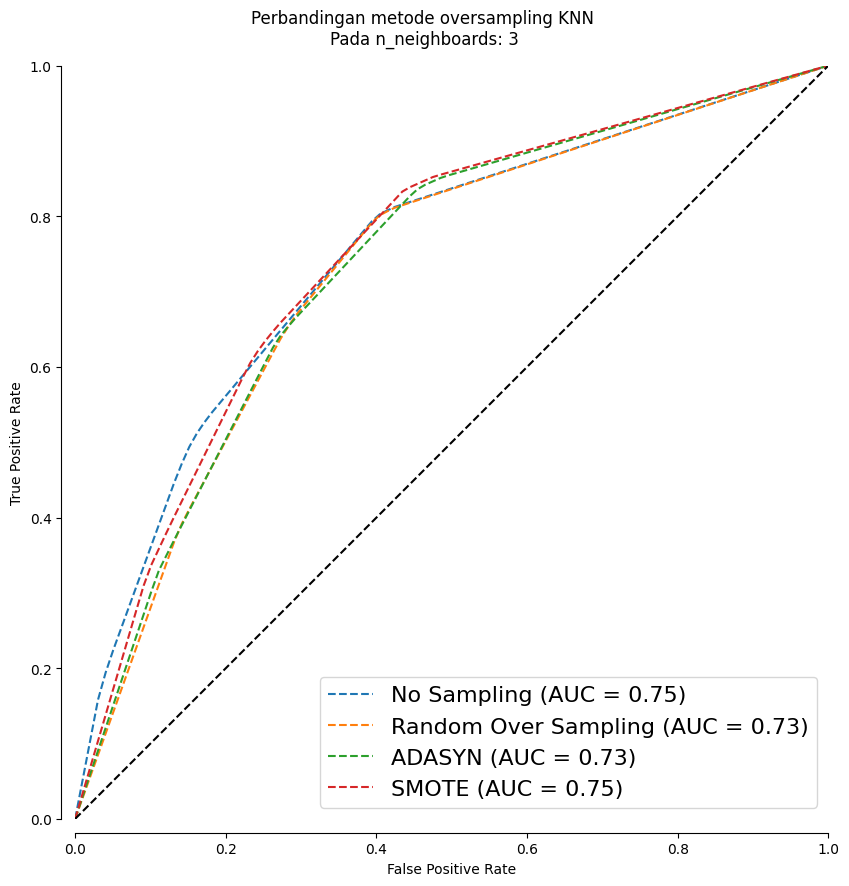

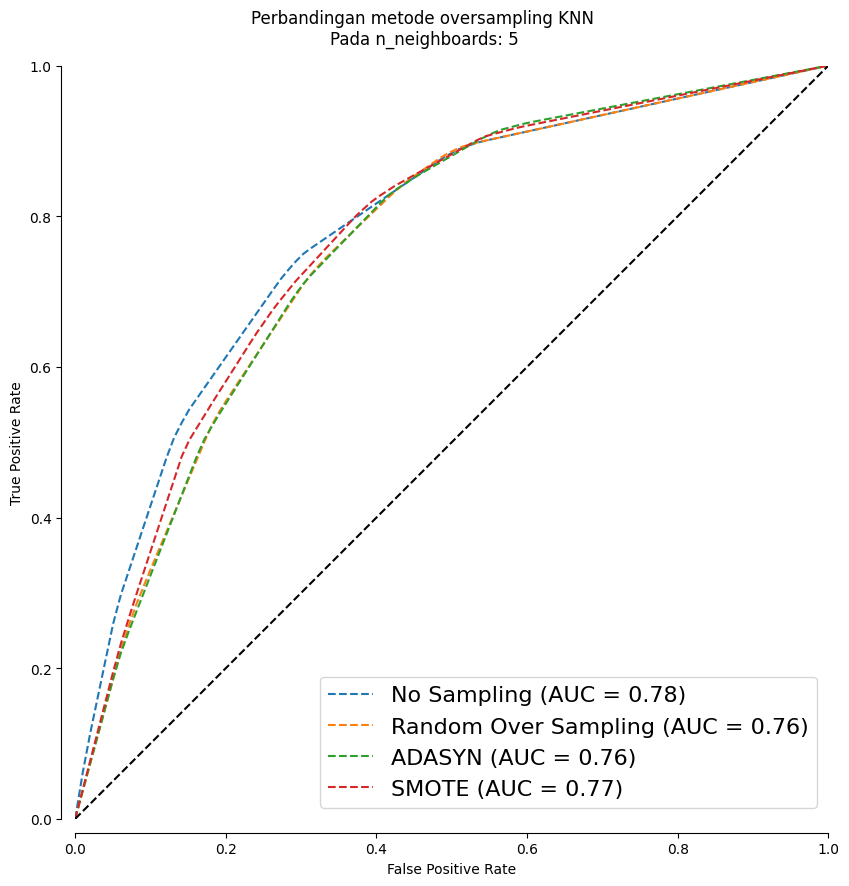

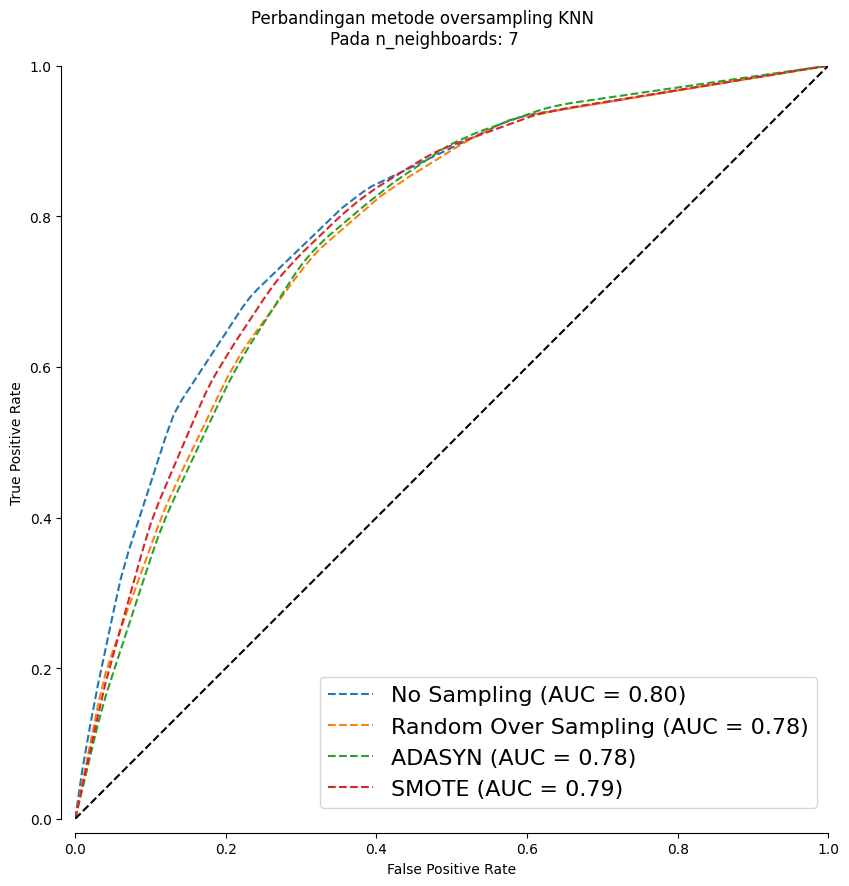

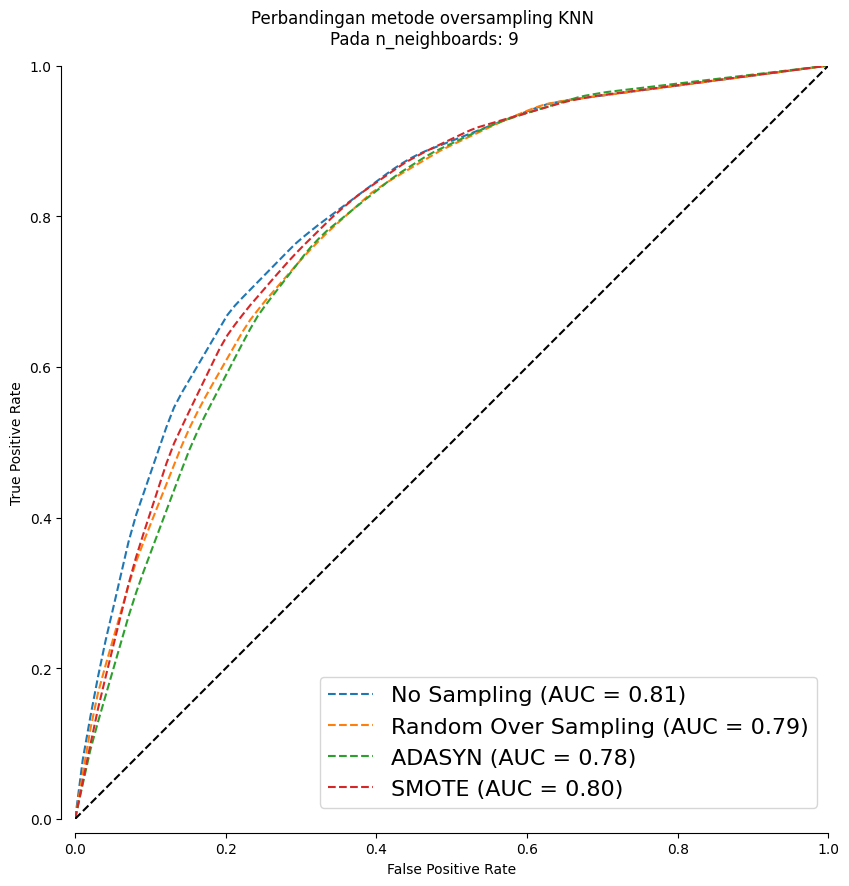

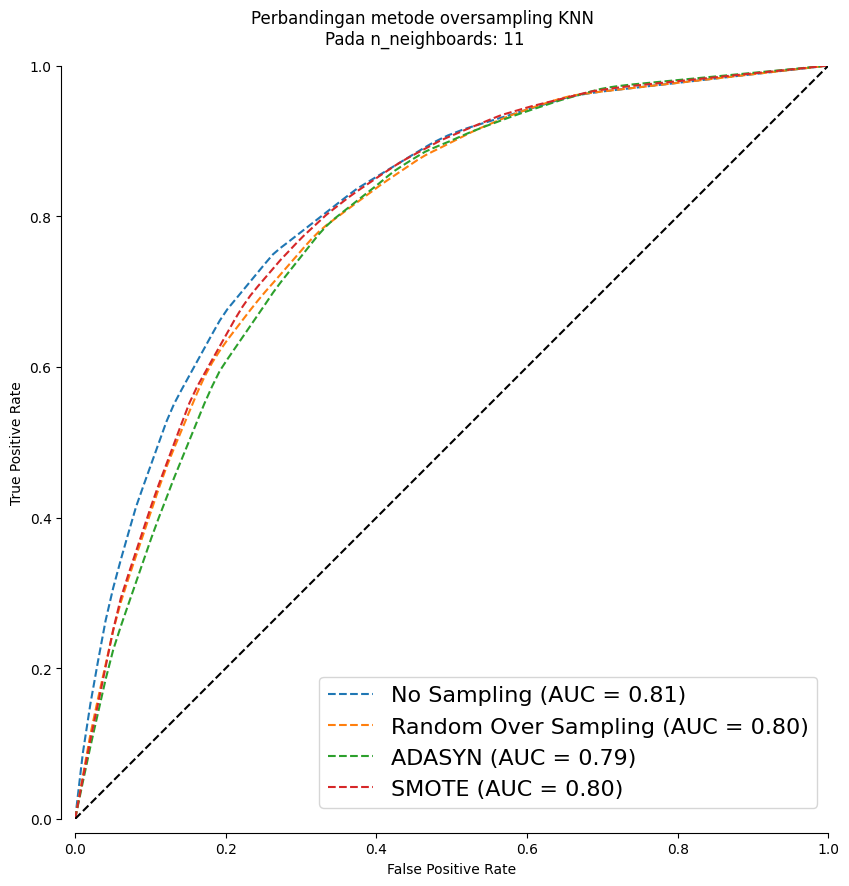

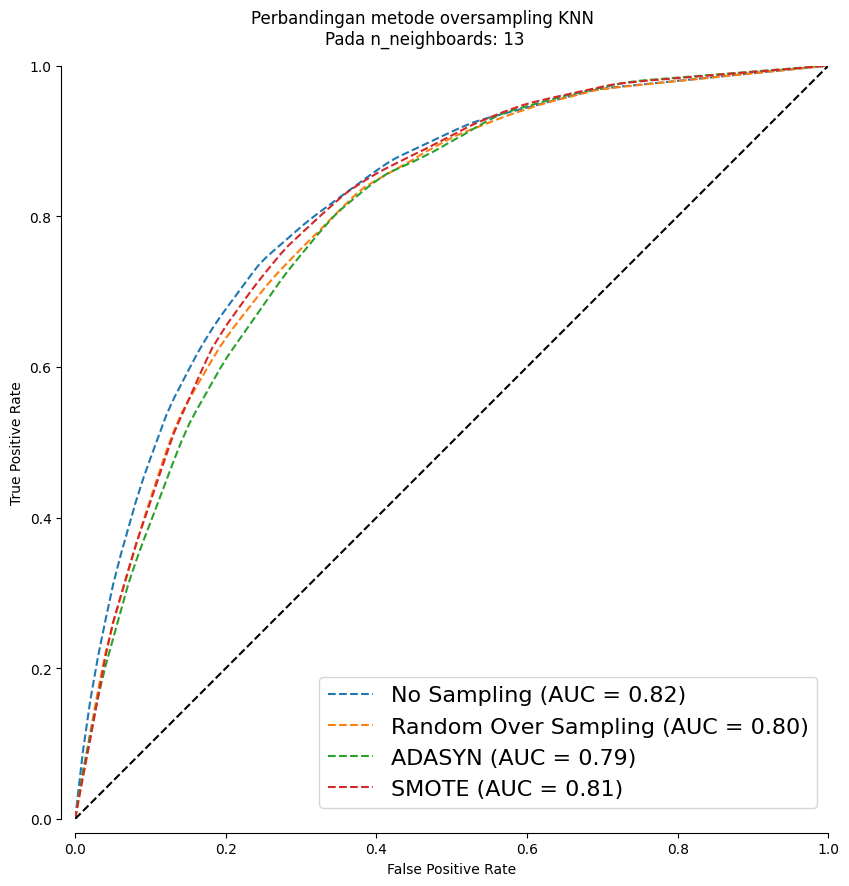

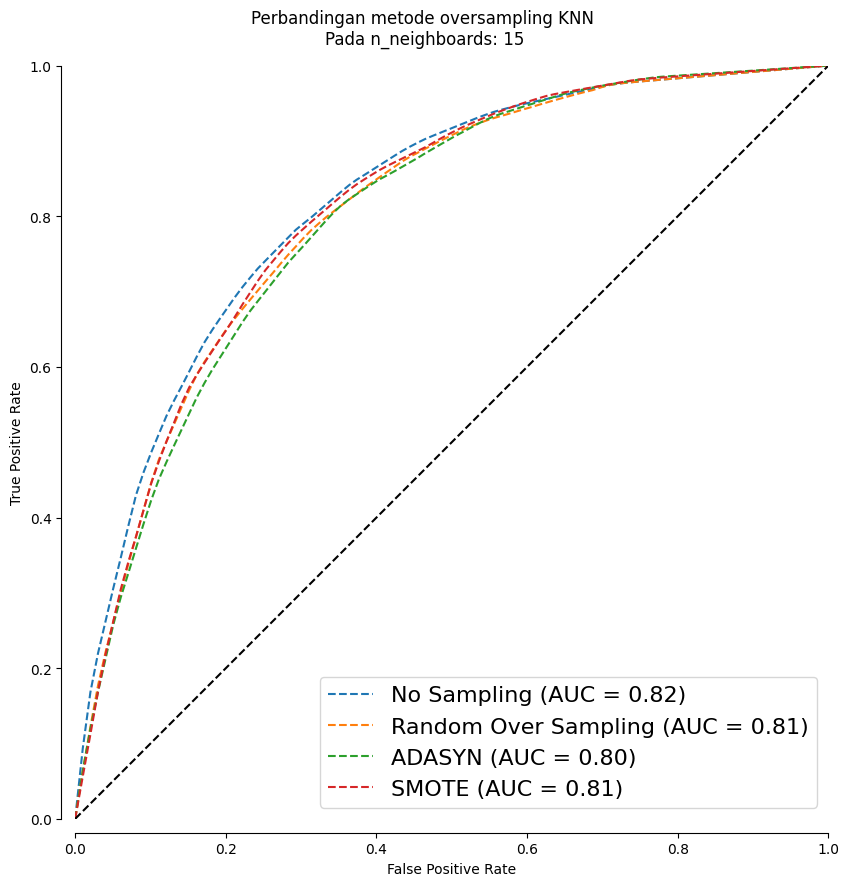

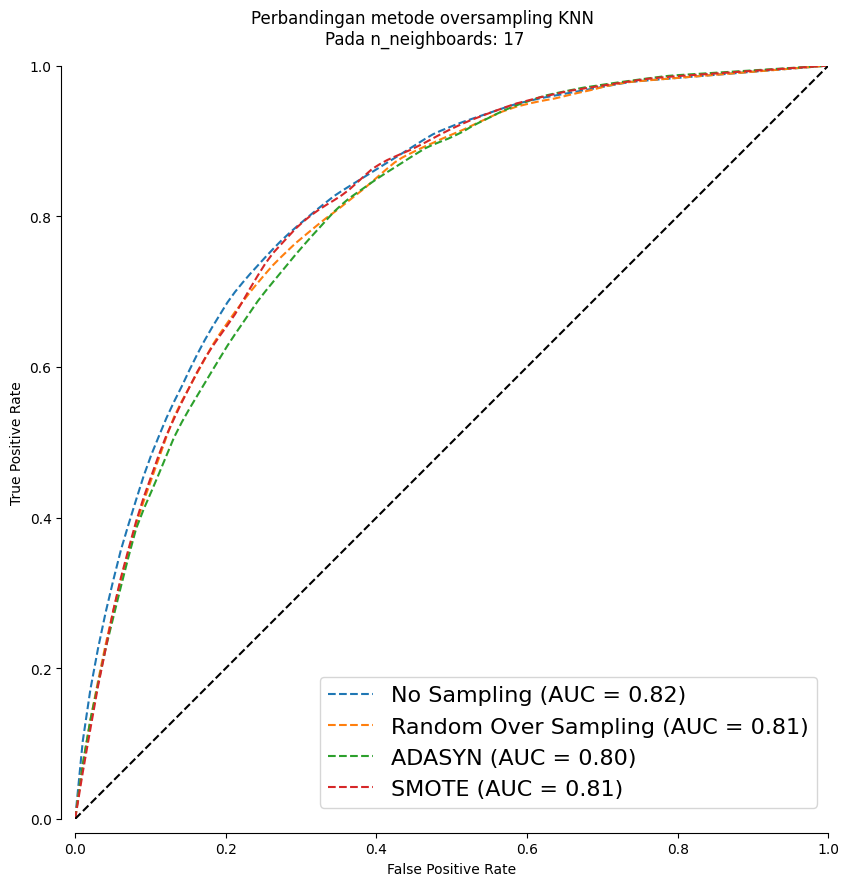

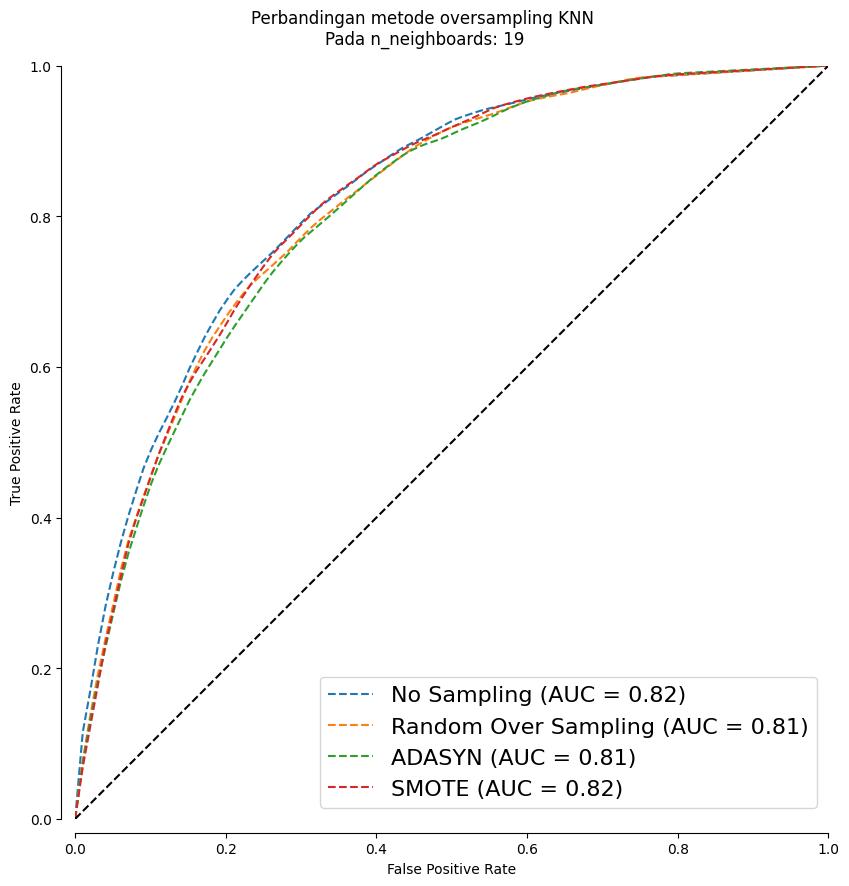

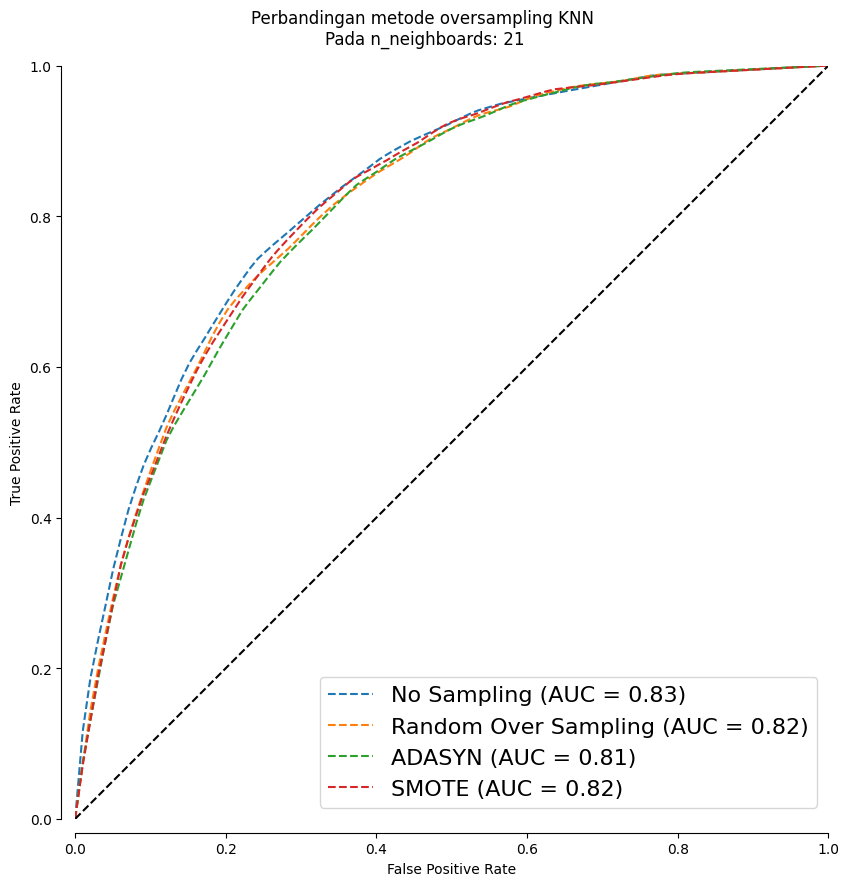

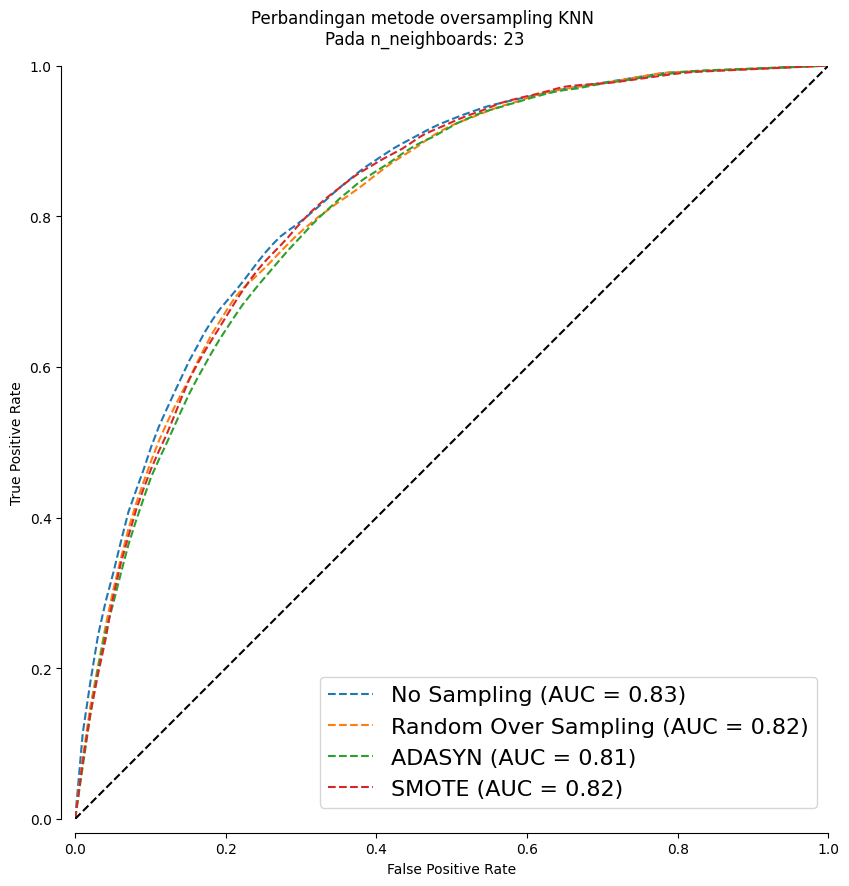

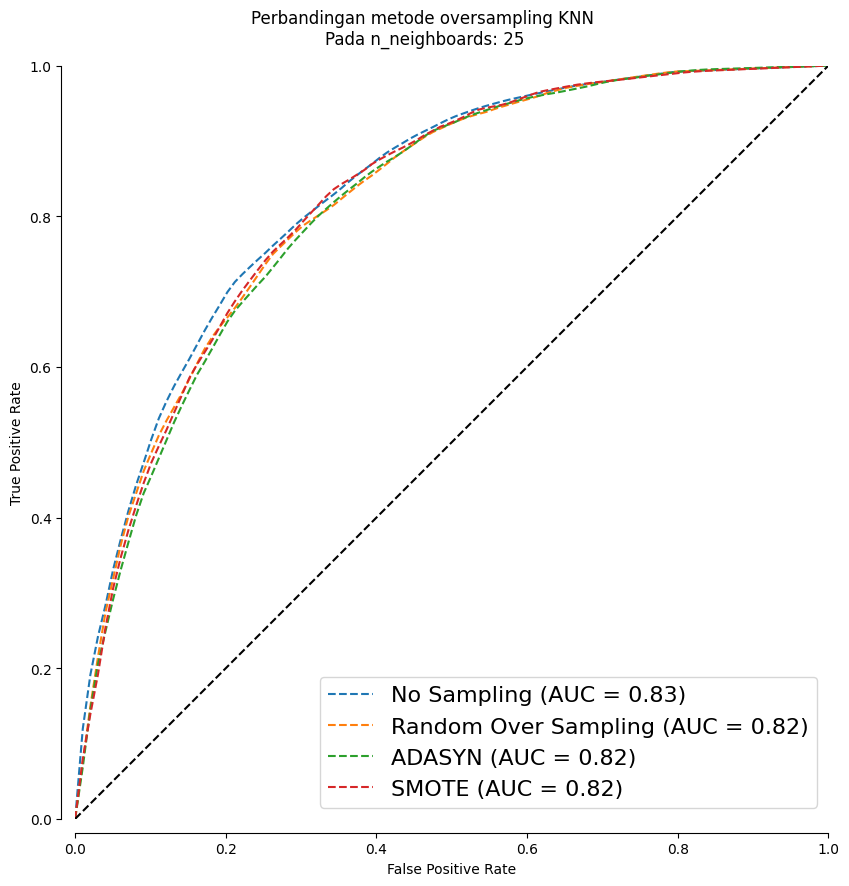

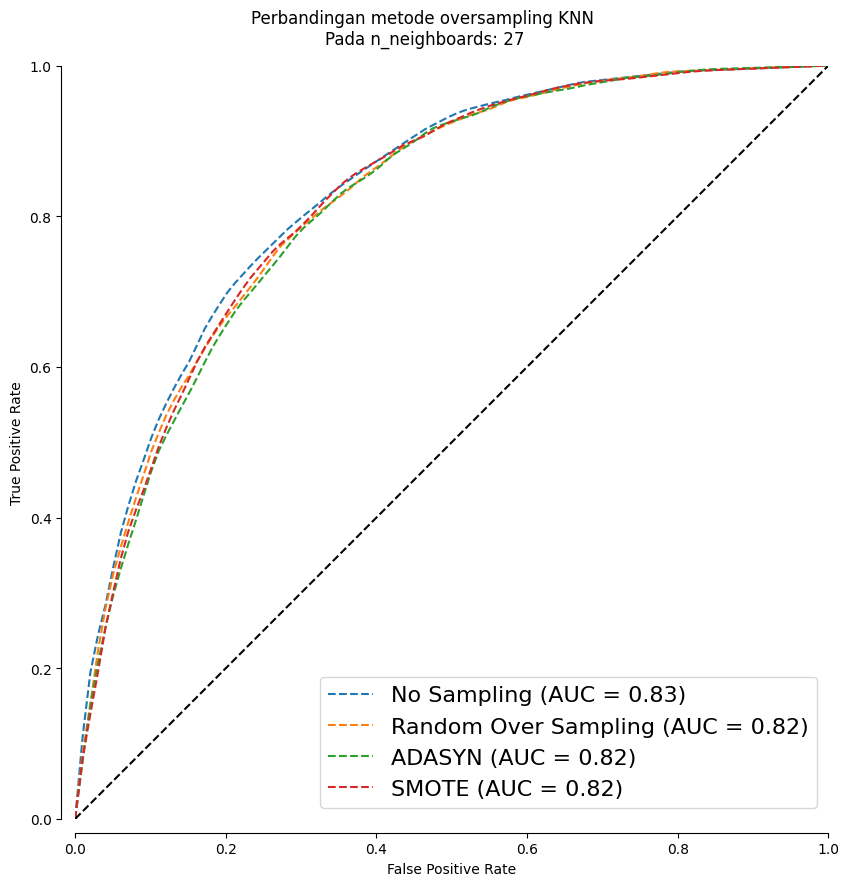

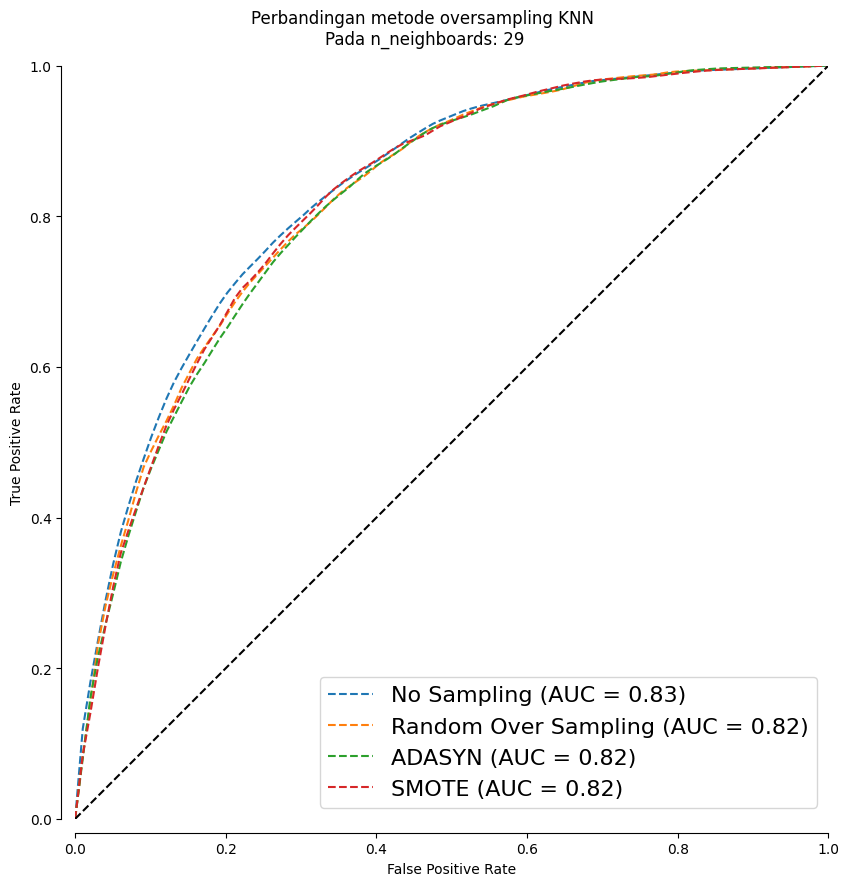

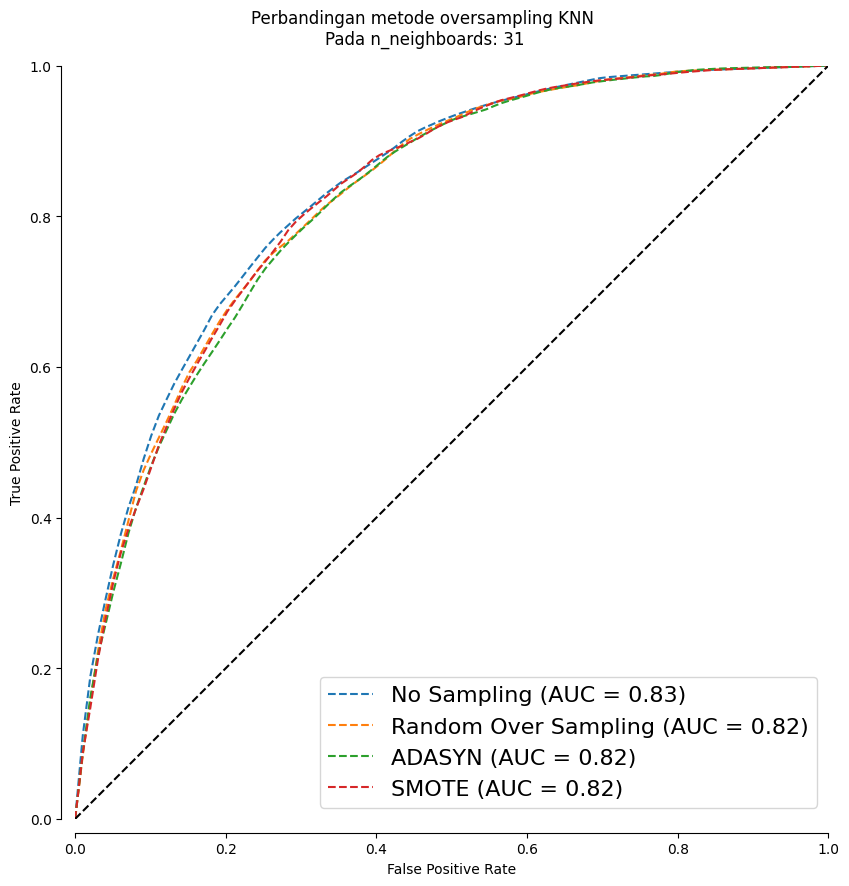

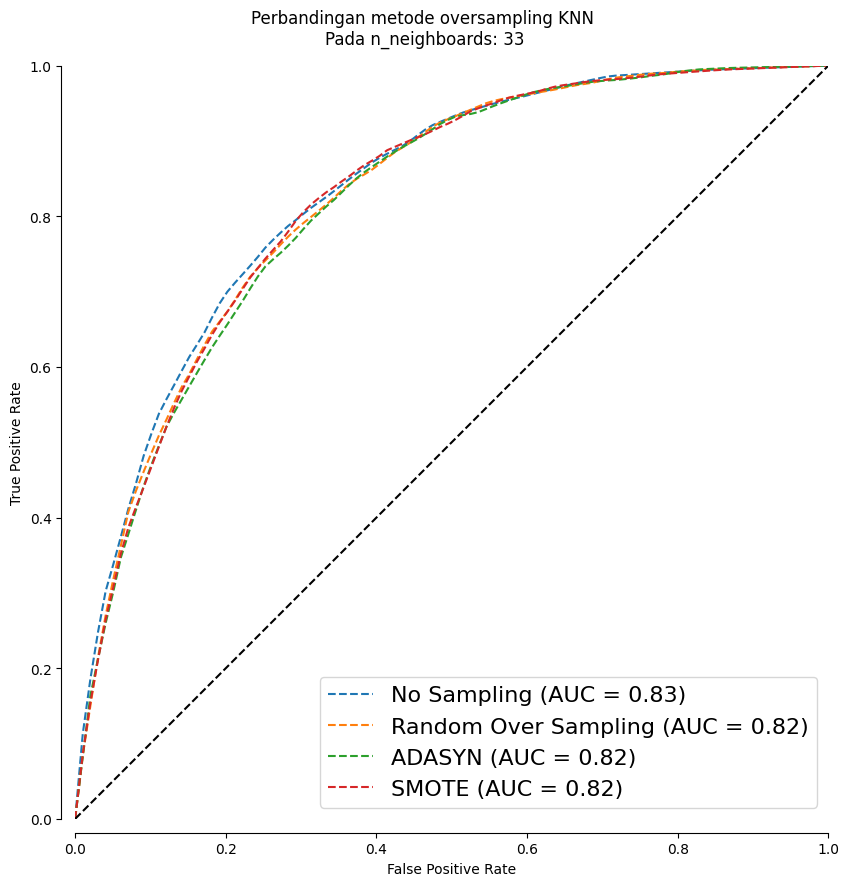

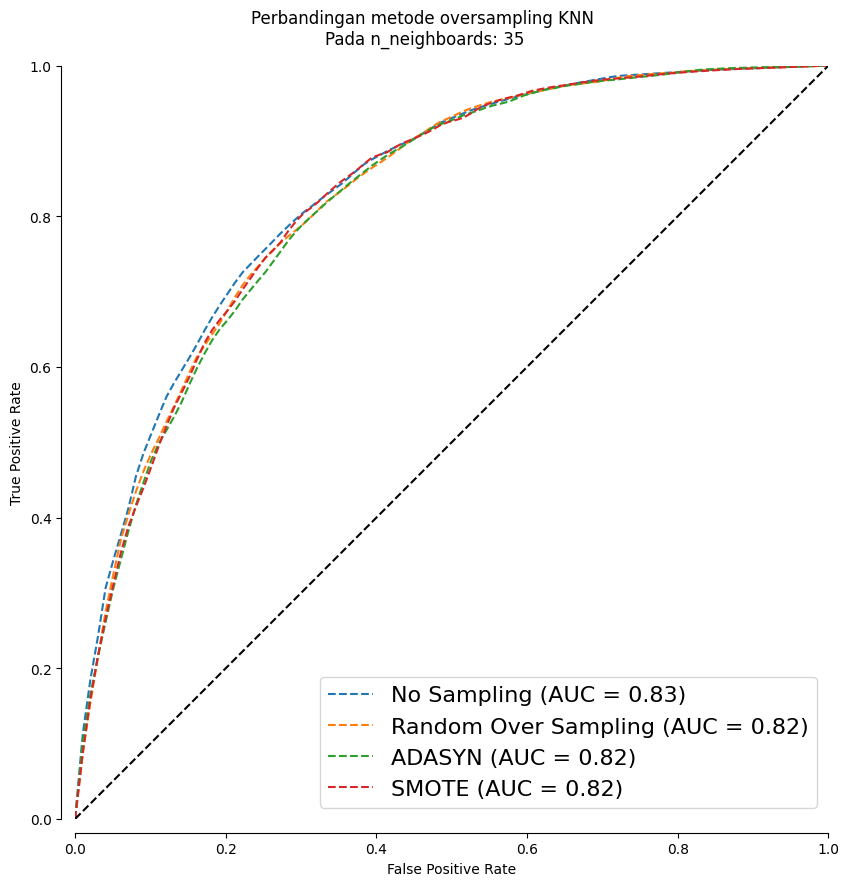

In [7]:
n_values = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
for i in n_values:
  classifier = KNeighborsClassifier(n_neighbors=i)
  cv = StratifiedKFold(n_splits=5)

  pos_label = 1

  pipelines = [
      ('No Sampling', make_pipeline(FunctionSampler(), classifier)),
      ('Random Over Sampling', make_pipeline(RandomOverSampler(random_state=42), classifier)),
      ('ADASYN', make_pipeline(ADASYN(random_state=42), classifier)),
      ('SMOTE', make_pipeline(SMOTE(random_state=42), classifier)),
  ]

  disp = []
  for name, model in pipelines:
      mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
      for train_index, test_index in cv.split(X, y):
          X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
          y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

          model.fit(X_train_cv, y_train_cv)
          y_proba = model.predict_proba(X_test_cv)

          pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
          fpr, tpr, _ = roc_curve(y_test_cv, y_proba[:, pos_label_idx], pos_label=pos_label)
          mean_tpr += np.interp(mean_fpr, fpr, tpr)
          mean_tpr[0] = 0.0

      mean_tpr /= cv.get_n_splits(X, y)
      mean_tpr[-1] = 1.0
      mean_auc = auc(mean_fpr, mean_tpr)

      disp.append(
          RocCurveDisplay(
              fpr=mean_fpr,
              tpr=mean_tpr,
              roc_auc=mean_auc,
              estimator_name=name,
          )
      )

  fig, ax = plt.subplots(figsize=(9, 9))
  for d in disp:
      d.plot(ax=ax, linestyle="--")
  ax.plot([0, 1], [0, 1], linestyle="--", color="k")
  ax.axis("square")
  fig.suptitle(f"Perbandingan metode oversampling KNN \nPada n_neighboards: {i}")
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  sns.despine(offset=10, ax=ax)
  plt.legend(loc="lower right", fontsize=16)
  plt.tight_layout()
  plt.show()

Kode di atas adalah benchmark(tolak ukur) untuk metode over-sampling, Tujuan dari tolok ukur ini adalah untuk mengevaluasi apakah penerapan metode over-sampling (seperti Random Over Sampling, ADASYN, dan SMOTE) meningkatkan performa model KNN dibandingkan dengan tidak melakukan penanganan ketidakseimbangan data sama sekali, hasil eksperimen digunakan untuk memahami dampak berbagai metode oversampling pada kinerja KNN menggunakan metrik ROC-AUC

dari hasil di atas..kita dapat menarik kesimpulan bahwa Semua metode over-sampling (Random Over Sampling, ADASYN, SMOTE) memberikan performa yang sangat mirip dengan No Sampling, dengan AUC yang sedikit lebih rendah atau sama.
Ini juga menunjukkan bahwa metode No Sampling sedikit lebih baik dalam hal AUC dibandingkan dengan metode oversampling lainnya. Namun, perbedaannya tidak terlalu signifikan

dengan kata lain, pada dataset ini nampaknya tidak diperlukan adalah handling imbalance dataset(dalam kasus ini over-sampling), dikarenakan nilai yang 11/12, bahkan kebanyakn menunjjukan nilai AUC yang lebih tinggi ketika tidak dilakukan over-sampling

adapun itu hanyalah hipotesis, dikarenakan tujuan awal dari membuat model ini adalah Klasifikasi pada cutomer yang berpotensi churn, mari kita liat nilai recall dan matriks-kesamaan dari perbandingan model yang dilakukan oversampling dan tidak

## Testing performa model no sampling VS SMOTE

Testing performa akan menggunakan parameter n_neigbors=21, sedangkan untuk parameter lainnya akan bernilai default

### No sampling

#### No sampling dan no cv

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=21)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"f1 score(no SMOTE dan no cv):{f1_score(y_test, y_pred)}")
print("\n")
print(f"Confusion matrix(no SMOTE dan no cv):\n{confusion_matrix(y_test, y_pred)}")
print("\n")
print(f"classification report(no SMOTE dan no cv):\n{classification_report(y_test, y_pred)}")
print("\n")
print(f"recall score(no SMOTE dan no cv):{recall_score(y_test,y_pred)}")

f1 score(no SMOTE dan no cv):0.5735567970204842


Confusion matrix(no SMOTE dan no cv):
[[1344  205]
 [ 253  308]]


classification report(no SMOTE dan no cv):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1549
           1       0.60      0.55      0.57       561

    accuracy                           0.78      2110
   macro avg       0.72      0.71      0.71      2110
weighted avg       0.78      0.78      0.78      2110



recall score(no SMOTE dan no cv):0.5490196078431373


**Kinerja Tanpa Cross-Validation**

- Model KNN memiliki F1 Score sebesar 0.5736 dan Recall Score sebesar 0.5490 pada kelas minoritas (1).

- Confusion matrix menunjukkan bahwa dari 561 sampel kelas 1, model hanya dapat memprediksi 308 sampel dengan benar (true positive), sedangkan 253 sampel salah prediksi (false negative).

#### No sampling dengan cv

In [9]:
cv = StratifiedKFold(n_splits=15)
cross_val_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring="f1")
print("Cross-validation f1 Scores:\n", cross_val_scores)
print("\nMean Cross-validation f1 Score:", cross_val_scores.mean())

y_pred = cross_val_predict(knn, X_train, y_train,cv=cv)
print(f"\nconfusion_matrix(no sampling dan no SMOTE):\n{confusion_matrix(y_train, y_pred)}")

cross_val_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring="recall")
print("Cross-validation Recall Scores:\n", cross_val_scores)
print("\nMean Cross-validation Recall Score:", cross_val_scores.mean())

Cross-validation f1 Scores:
 [0.63855422 0.58385093 0.59550562 0.64670659 0.57303371 0.50909091
 0.49689441 0.65030675 0.50299401 0.6        0.60240964 0.64327485
 0.6091954  0.63529412 0.62576687]

Mean Cross-validation f1 Score: 0.5941918682767718

confusion_matrix(no sampling dan no SMOTE):
[[3158  456]
 [ 562  746]]
Cross-validation Recall Scores:
 [0.60227273 0.53409091 0.60227273 0.62068966 0.5862069  0.48275862
 0.45977011 0.6091954  0.48275862 0.55172414 0.57471264 0.63218391
 0.6091954  0.62068966 0.5862069 ]

Mean Cross-validation Recall Score: 0.5703152211772902


**Kinerja dengan Cross-Validation**

- Rata-rata F1 Score pada cross-validation adalah 0.5942, sedikit lebih tinggi dibandingkan tanpa cross-validation.

- Rata-rata Recall Score pada cross-validation adalah 0.5703, juga sedikit lebih tinggi dibandingkan tanpa cross-validation.

- Confusion matrix menunjukkan hasil serupa dengan lebih banyak data (menggabungkan semua fold).


Meskipun tanpa metode oversampling, performa model cukup baik, namun Recall Score untuk kelas minoritas (1) masih di sekitar 0.55-0.57. Ini berarti hampir separuh dari kelas minoritas tidak terdeteksi dengan baik.

Berdasarkan hasil ROC sebelumnya, metode oversampling tidak memberikan peningkatan signifikan, namun kita akan uji kembali untuk memastikan.

### SMOTE

#### No cv

In [10]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_res, y_train_res)

y_pred_sm = knn.predict(X_test_sm)

print(f"f1 Score (dengan SMOTE dan no cv): {f1_score(y_test_sm, y_pred_sm)}")
print("\n")
print(f"Confusion matrix (dengan SMOTE dan no cv): \n{confusion_matrix(y_test_sm, y_pred_sm)}")
print("\n")
print(f"classification_report (dengan SMOTE dan no cv): \n{classification_report(y_test_sm, y_pred_sm)}")
print("\n")
print(f"recall score (dengan SMOTE dan no cv): {recall_score(y_test_sm,y_pred_sm)}")

f1 Score (dengan SMOTE dan no cv): 0.6009327115256496


Confusion matrix (dengan SMOTE dan no cv): 
[[1060  489]
 [ 110  451]]


classification_report (dengan SMOTE dan no cv): 
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1549
           1       0.48      0.80      0.60       561

    accuracy                           0.72      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.72      0.73      2110



recall score (dengan SMOTE dan no cv): 0.803921568627451


**Kinerja SMOTE pada dataset Tanpa Cross-Validation**

- Dengan menerapkan SMOTE, F1 Score meningkat dari 0.5736 menjadi 0.6009 pada evaluasi tanpa cross-validation.

- Recall Score untuk kelas minoritas meningkat signifikan dari 0.5490 menjadi 0.8039 setelah menerapkan SMOTE.

- Setelah SMOTE: False negatives menurun drastis menjadi 110, menunjukkan peningkatan dalam mendeteksi kelas minoritas.

#### Dengan cv

In [11]:
cv = StratifiedKFold(n_splits=15)
cross_val_scores_sm = cross_val_score(knn, X_train_res, y_train_res, cv=cv, scoring="f1")
print("Cross-validation Recall Scores:\n", cross_val_scores_sm)
print("\nMean Cross-validation Recall Score:", cross_val_scores_sm.mean())

y_pred_cv = cross_val_predict(knn, X_train_res, y_train_res, cv=cv)
print(f"\nconfusion_matrix(SMOTE dan cv):\n{confusion_matrix(y_train_res, y_pred_cv)}")

cross_val_scores_sm = cross_val_score(knn, X_train_res, y_train_res, cv=cv, scoring="recall")
print("\nCross-validation Recall Scores:\n", cross_val_scores_sm)
print("\nMean Cross-validation Recall Score:", cross_val_scores_sm.mean())

Cross-validation Recall Scores:
 [0.78642715 0.79125249 0.77165354 0.77932406 0.78638941 0.83455882
 0.81818182 0.83082707 0.83643123 0.80602637 0.81767956 0.8365019
 0.81191806 0.84410646 0.83548983]

Mean Cross-validation Recall Score: 0.8124511843493717

confusion_matrix(SMOTE dan cv):
[[2532 1082]
 [ 398 3216]]

Cross-validation Recall Scores:
 [0.81742739 0.82572614 0.81327801 0.81327801 0.86307054 0.94190871
 0.93360996 0.91701245 0.93360996 0.8879668  0.92116183 0.91286307
 0.90456432 0.92116183 0.94166667]

Mean Cross-validation Recall Score: 0.8898870447210697


**Kinerja SMOTE pada dataset dengan Cross-Validation**

- Mean Cross-validation F1 Score meningkat menjadi 0.8125 dengan SMOTE, menunjukkan bahwa model lebih stabil dan memiliki performa yang lebih baik di berbagai subset data.

- Mean Cross-validation Recall Score meningkat menjadi 0.8899, yang menunjukkan bahwa model menjadi lebih efektif dalam mendeteksi kelas minoritas setelah menerapkan SMOTE.


**kesimpulan**

Saat menggunakan SMOTE, recall untuk kelas minoritas meningkat secara signifikan dari 0.55 menjadi 0.80. Namun, precision untuk kelas minoritas menurun dari 0.60 menjadi 0.48. Ini berarti

- Setelah menerapkan SMOTE, recall meningkat signifikan. Ini berarti model menjadi jauh lebih baik dalam mendeteksi pelanggan yang akan churn. Ini sangat penting dalam konteks customer churn karena tujuan utama adalah mengidentifikasi sebanyak mungkin pelanggan yang berisiko agar Anda dapat mengambil tindakan untuk mempertahankan mereka.

- Meskipun precision sedikit menurun, peningkatan recall memberikan manfaat yang lebih besar karena Anda dapat mengidentifikasi lebih banyak pelanggan yang berisiko churn. Dalam kasus ini, false positives lebih bisa diterima dibandingkan dengan false negatives.

**karena bisnis problem di sini adalah mendeteksi pelanggan yang akan churn dan menghindari terlalu banyak false positives, dengan kata lain kita ingin mendeteksi sebanyak mungkin pelanggan yang churn tapi Efisiensi Sumber Daya tetap penting, maka utamannya adalah f1 score**



# Feature selection

In [12]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_res_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_sm)

In [13]:
X_test_sel

array([[ 1.16438964,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.54685673,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.7913205 ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59397418,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.11727219,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28662152,  0.        ,  1.        , ...,  1.        ,
         0.        ,  1.        ]])

# Dimensional reduction

In [14]:
pca = PCA(n_components=5)
X_train_res_pca = pca.fit_transform(X_train_res_sel)
X_test_pca = pca.transform(X_test_sel)

In [15]:
X_test_pca

array([[ 1.89499432,  0.3380133 ,  0.01201274,  0.12738173, -0.10316275],
       [ 0.28898133,  1.183278  , -0.29875379, -0.16912789, -0.23261251],
       [-0.74198316, -0.17124525, -0.0591963 ,  0.17189233, -0.94440264],
       ...,
       [ 1.43320932,  0.63152123, -0.0603292 ,  0.11674912, -0.12433972],
       [-0.75931229,  0.76780008,  0.81907818,  0.32827833,  0.22124225],
       [ 1.10842653, -1.15032953, -0.51849323,  0.44413213, -0.35174848]])

# Analisis hyperparameter

kita akan melihat seluruh learning curve untuk kombinasi berbagai parameter demi mencegah adannya overfitting kedepannya ketika melakukan hyperparameter tunning


## Untuk metric minkowski dan weight uniform

>1, train recall: 0.743, test recall: 0.578
>1, train f1: 0.753, test f1: 0.497
Recall Rentang adalah = 0.165
F1 Rentang adalah = 0.256


>2, train recall: 0.585, test recall: 0.440
>2, train f1: 0.679, test f1: 0.458
Recall Rentang adalah = 0.145
F1 Rentang adalah = 0.221


>3, train recall: 0.771, test recall: 0.661
>3, train f1: 0.766, test f1: 0.548
Recall Rentang adalah = 0.109
F1 Rentang adalah = 0.219


>4, train recall: 0.668, test recall: 0.594
>4, train f1: 0.722, test f1: 0.547
Recall Rentang adalah = 0.074
F1 Rentang adalah = 0.174


>5, train recall: 0.778, test recall: 0.709
>5, train f1: 0.763, test f1: 0.569
Recall Rentang adalah = 0.068
F1 Rentang adalah = 0.194


>6, train recall: 0.725, test recall: 0.608
>6, train f1: 0.745, test f1: 0.556
Recall Rentang adalah = 0.117
F1 Rentang adalah = 0.190


>7, train recall: 0.804, test recall: 0.690
>7, train f1: 0.776, test f1: 0.566
Recall Rentang adalah = 0.115
F1 Rentang adalah = 0.210


>8, train recall: 0.753, test reca

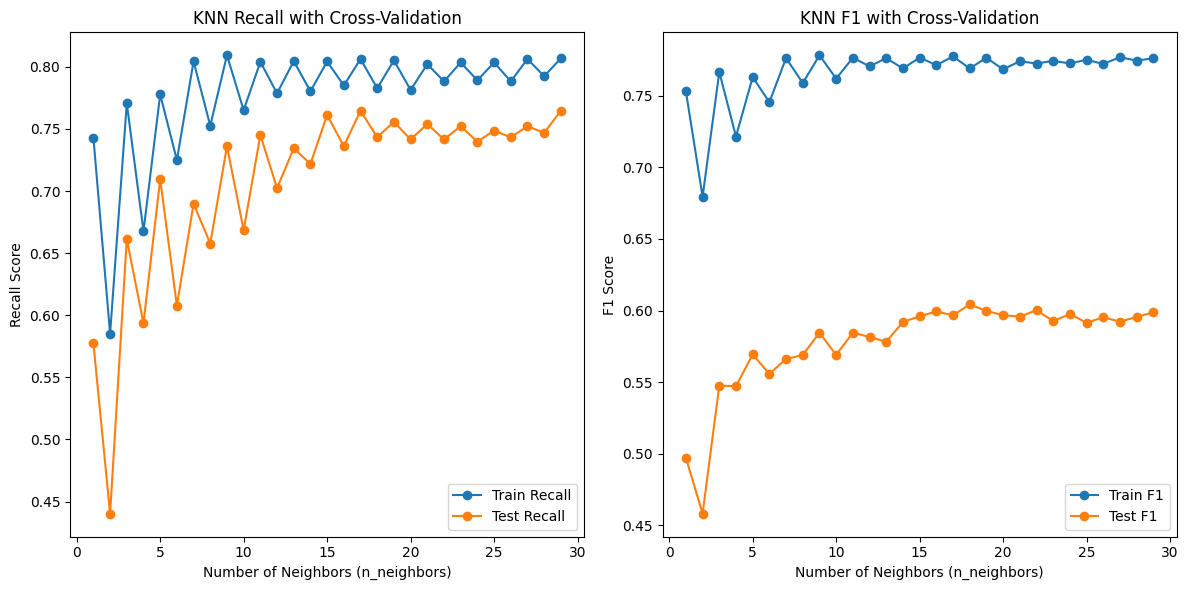

In [16]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="uniform", metric="minkowski")

    train_recalls_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric minkowski dan weight distance

>1, train recall: 0.743, test recall: 0.578
>1, train f1: 0.753, test f1: 0.497
Recall Rentang adalah = 0.165
F1 Rentang adalah = 0.256


>2, train recall: 0.670, test recall: 0.490
>2, train f1: 0.718, test f1: 0.461
Recall Rentang adalah = 0.180
F1 Rentang adalah = 0.257


>3, train recall: 0.744, test recall: 0.629
>3, train f1: 0.757, test f1: 0.536
Recall Rentang adalah = 0.115
F1 Rentang adalah = 0.221


>4, train recall: 0.722, test recall: 0.606
>4, train f1: 0.746, test f1: 0.532
Recall Rentang adalah = 0.116
F1 Rentang adalah = 0.214


>5, train recall: 0.749, test recall: 0.649
>5, train f1: 0.760, test f1: 0.545
Recall Rentang adalah = 0.100
F1 Rentang adalah = 0.215


>6, train recall: 0.744, test recall: 0.610
>6, train f1: 0.760, test f1: 0.536
Recall Rentang adalah = 0.135
F1 Rentang adalah = 0.224


>7, train recall: 0.766, test recall: 0.626
>7, train f1: 0.771, test f1: 0.543
Recall Rentang adalah = 0.141
F1 Rentang adalah = 0.229


>8, train recall: 0.760, test reca

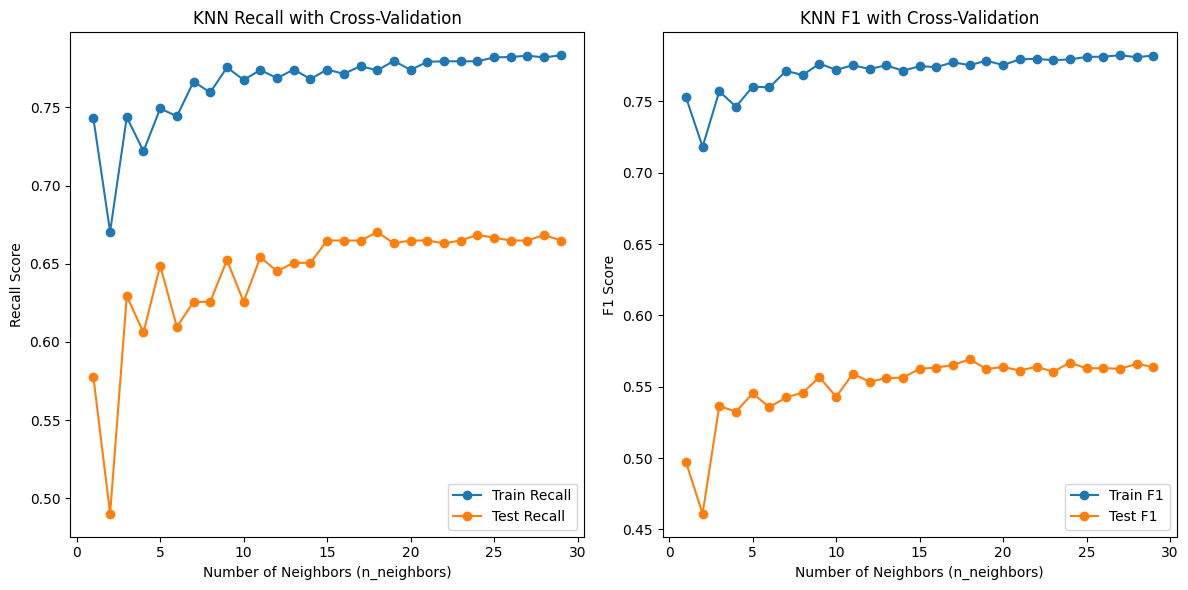

In [17]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="distance", metric="minkowski")

    train_recalls_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric manhattan dan weight uniform

>1, train recall: 0.744, test recall: 0.579
>1, train f1: 0.754, test f1: 0.498
Recall Rentang adalah = 0.164
F1 Rentang adalah = 0.256


>2, train recall: 0.584, test recall: 0.435
>2, train f1: 0.678, test f1: 0.453
Recall Rentang adalah = 0.149
F1 Rentang adalah = 0.225


>3, train recall: 0.770, test recall: 0.663
>3, train f1: 0.765, test f1: 0.548
Recall Rentang adalah = 0.107
F1 Rentang adalah = 0.217


>4, train recall: 0.668, test recall: 0.597
>4, train f1: 0.721, test f1: 0.548
Recall Rentang adalah = 0.071
F1 Rentang adalah = 0.173


>5, train recall: 0.776, test recall: 0.709
>5, train f1: 0.763, test f1: 0.568
Recall Rentang adalah = 0.067
F1 Rentang adalah = 0.196


>6, train recall: 0.727, test recall: 0.611
>6, train f1: 0.748, test f1: 0.556
Recall Rentang adalah = 0.116
F1 Rentang adalah = 0.192


>7, train recall: 0.808, test recall: 0.697
>7, train f1: 0.779, test f1: 0.572
Recall Rentang adalah = 0.111
F1 Rentang adalah = 0.207


>8, train recall: 0.752, test reca

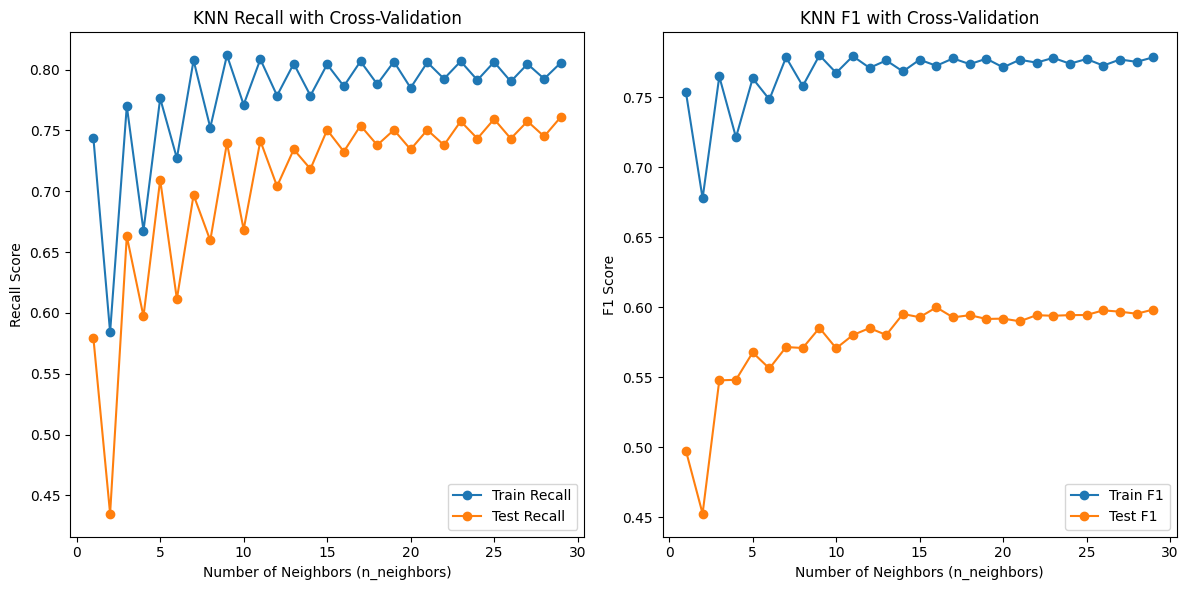

In [18]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="uniform", metric="manhattan")

    train_recalls_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric manhattan dan weight distance

>1, train recall: 0.744, test recall: 0.579
>1, train f1: 0.754, test f1: 0.498
Recall Rentang adalah = 0.164
F1 Rentang adalah = 0.256


>2, train recall: 0.671, test recall: 0.490
>2, train f1: 0.719, test f1: 0.460
Recall Rentang adalah = 0.181
F1 Rentang adalah = 0.259


>3, train recall: 0.745, test recall: 0.635
>3, train f1: 0.758, test f1: 0.538
Recall Rentang adalah = 0.110
F1 Rentang adalah = 0.220


>4, train recall: 0.722, test recall: 0.610
>4, train f1: 0.748, test f1: 0.531
Recall Rentang adalah = 0.113
F1 Rentang adalah = 0.217


>5, train recall: 0.750, test recall: 0.647
>5, train f1: 0.762, test f1: 0.545
Recall Rentang adalah = 0.103
F1 Rentang adalah = 0.218


>6, train recall: 0.745, test recall: 0.611
>6, train f1: 0.760, test f1: 0.537
Recall Rentang adalah = 0.133
F1 Rentang adalah = 0.223


>7, train recall: 0.767, test recall: 0.624
>7, train f1: 0.772, test f1: 0.545
Recall Rentang adalah = 0.143
F1 Rentang adalah = 0.227


>8, train recall: 0.761, test reca

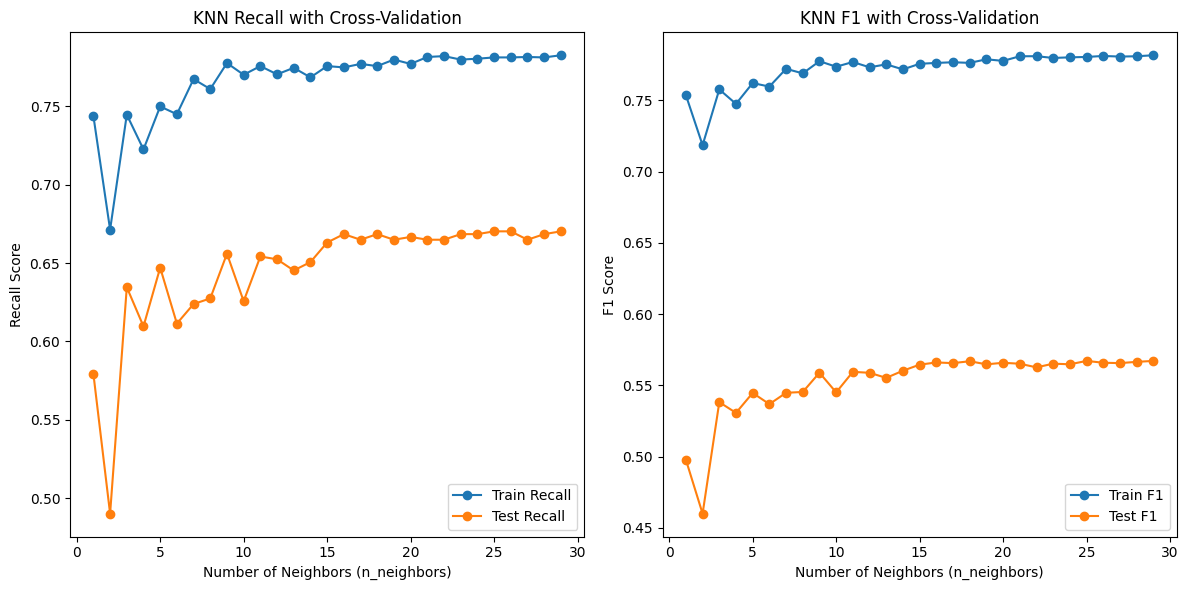

In [19]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="distance", metric="manhattan")

    train_recalls_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric euclidean dan weight uniform

>1, train recall: 0.743, test recall: 0.578
>1, train f1: 0.753, test f1: 0.497
Recall Rentang adalah = 0.165
F1 Rentang adalah = 0.256


>2, train recall: 0.585, test recall: 0.440
>2, train f1: 0.679, test f1: 0.458
Recall Rentang adalah = 0.145
F1 Rentang adalah = 0.221


>3, train recall: 0.771, test recall: 0.661
>3, train f1: 0.766, test f1: 0.548
Recall Rentang adalah = 0.109
F1 Rentang adalah = 0.219


>4, train recall: 0.668, test recall: 0.594
>4, train f1: 0.722, test f1: 0.547
Recall Rentang adalah = 0.074
F1 Rentang adalah = 0.174


>5, train recall: 0.778, test recall: 0.709
>5, train f1: 0.763, test f1: 0.569
Recall Rentang adalah = 0.068
F1 Rentang adalah = 0.194


>6, train recall: 0.725, test recall: 0.608
>6, train f1: 0.745, test f1: 0.556
Recall Rentang adalah = 0.117
F1 Rentang adalah = 0.190


>7, train recall: 0.804, test recall: 0.690
>7, train f1: 0.776, test f1: 0.566
Recall Rentang adalah = 0.115
F1 Rentang adalah = 0.210


>8, train recall: 0.753, test reca

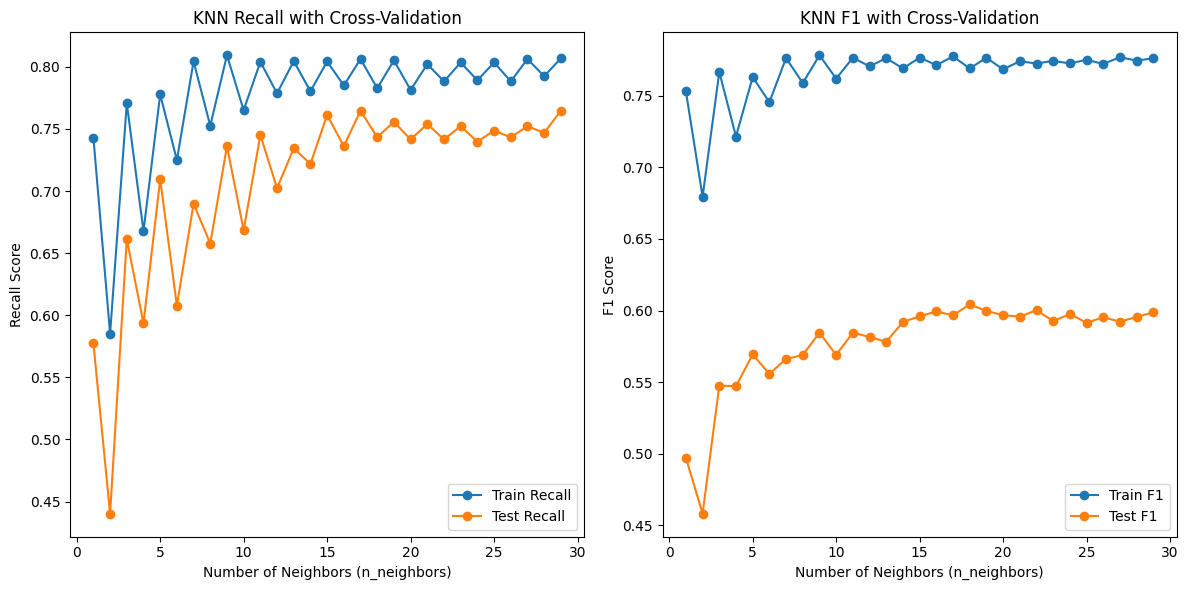

In [20]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="uniform", metric="euclidean")

    train_recalls_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric euclidean dan weight distance

>1, train recall: 0.743, test recall: 0.578
>1, train f1: 0.753, test f1: 0.497
Recall Rentang adalah = 0.165
F1 Rentang adalah = 0.256


>2, train recall: 0.670, test recall: 0.490
>2, train f1: 0.718, test f1: 0.461
Recall Rentang adalah = 0.180
F1 Rentang adalah = 0.257


>3, train recall: 0.744, test recall: 0.629
>3, train f1: 0.757, test f1: 0.536
Recall Rentang adalah = 0.115
F1 Rentang adalah = 0.221


>4, train recall: 0.722, test recall: 0.606
>4, train f1: 0.746, test f1: 0.532
Recall Rentang adalah = 0.116
F1 Rentang adalah = 0.214


>5, train recall: 0.749, test recall: 0.649
>5, train f1: 0.760, test f1: 0.545
Recall Rentang adalah = 0.100
F1 Rentang adalah = 0.215


>6, train recall: 0.744, test recall: 0.610
>6, train f1: 0.760, test f1: 0.536
Recall Rentang adalah = 0.135
F1 Rentang adalah = 0.224


>7, train recall: 0.766, test recall: 0.626
>7, train f1: 0.771, test f1: 0.543
Recall Rentang adalah = 0.141
F1 Rentang adalah = 0.229


>8, train recall: 0.760, test reca

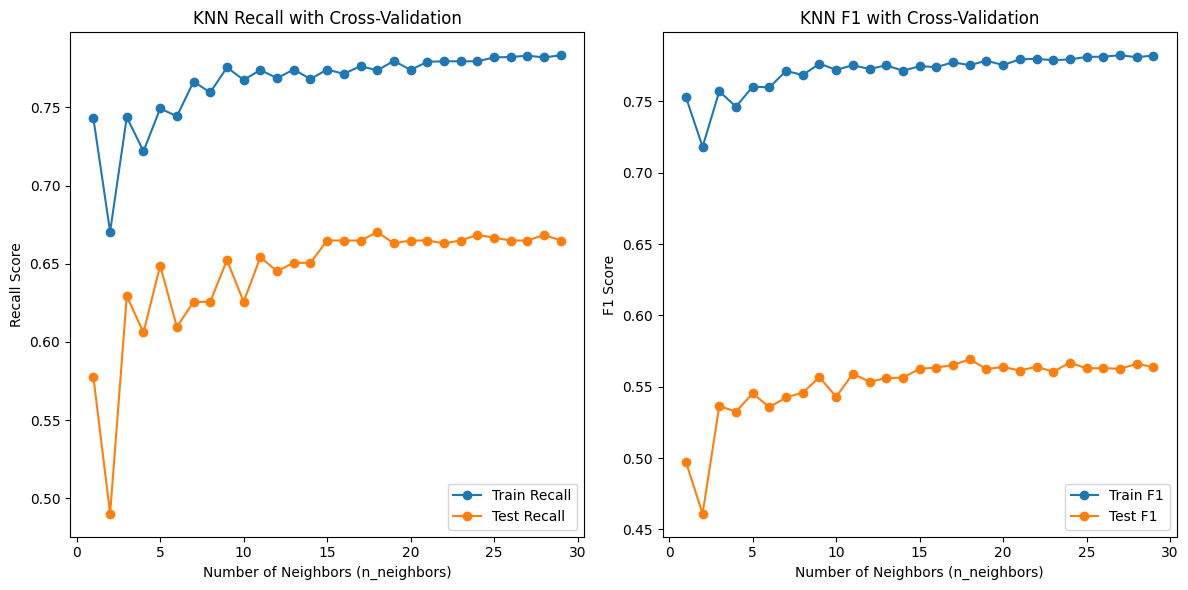

In [21]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="distance", metric="euclidean")

    train_recalls_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

# Hyperparameter tunning jika ingin recall sebagai acuan

## Bayesian Optimization

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 11, 'uniform'] before, using random point ['manhattan', 17, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['euclidean', 17, 'uniform'] before, using random point ['manhattan', 11, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 11, 'uniform'] before, using random point ['euclidean', 11, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['minkowski', 15, 'uniform'] before, using random point ['manhattan', 17, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: Us

Best Parameters: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 11), ('weights', 'uniform')])


Recall: 0.7415329768270945


F1 Score: 0.5801952580195258


Confusion Matrix:
[[1092  457]
 [ 145  416]]


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1549
           1       0.48      0.74      0.58       561

    accuracy                           0.71      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.77      0.71      0.73      2110





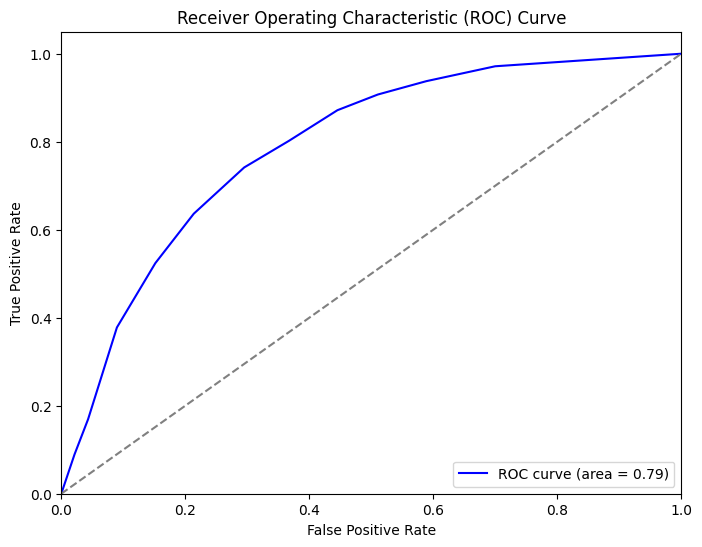

In [22]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_space = {
    "n_neighbors": Categorical([11, 13, 15, 17]),
    "weights": Categorical(["uniform"]),
    "metric": Categorical(["euclidean", "manhattan", "minkowski"])
}

knn = KNeighborsClassifier()

bayes_search = BayesSearchCV(estimator=knn, search_spaces=param_space, n_iter=30, cv=cv, n_jobs=-1, random_state=42, scoring="recall")
bayes_search.fit(X_train_res_pca, y_train_res)

best_knn = bayes_search.best_estimator_

y_pred = best_knn.predict(X_test_pca)

recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print(f"Best Parameters: {bayes_search.best_params_}")
print("\n")
print(f"Recall: {recall}")
print("\n")
print(f"F1 Score: {f1}")
print("\n")
print(f"Confusion Matrix:\n{conf_matrix}")
print("\n")
print(f"Classification Report:\n{class_report}")
print("\n")

y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Grid Search

Accuracy: 0.7146919431279621
Recall: 0.7415329768270945
F1 Score: 0.5801952580195258
Confusion Matrix:
 [[1092  457]
 [ 145  416]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78      1549
           1       0.48      0.74      0.58       561

    accuracy                           0.71      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.77      0.71      0.73      2110

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


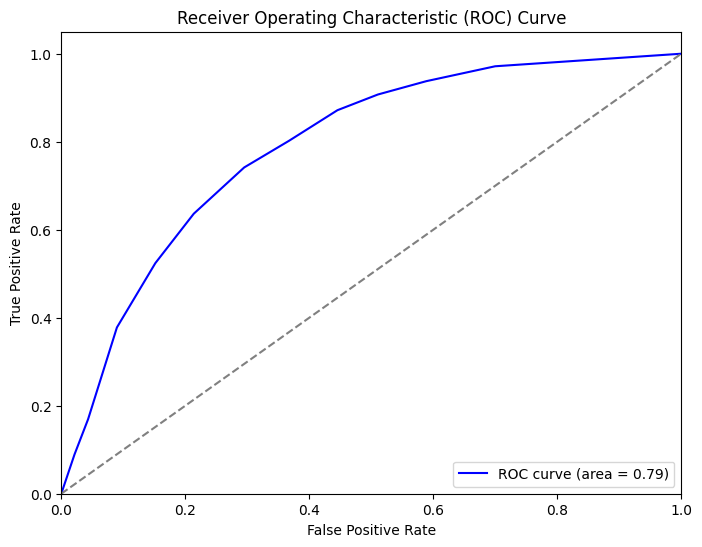

In [23]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_grid = {
    "n_neighbors": [11, 13, 15, 17],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="recall")
grid_search.fit(X_train_res_pca, y_train_res)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_pca)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Best Parameters:", grid_search.best_params_)
print("=====================================")

y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Random Search

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.7146919431279621
Recall: 0.7415329768270945
F1 Score: 0.5801952580195258
Confusion Matrix:
 [[1092  457]
 [ 145  416]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78      1549
           1       0.48      0.74      0.58       561

    accuracy                           0.71      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.77      0.71      0.73      2110

Best Parameters: {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'manhattan'}


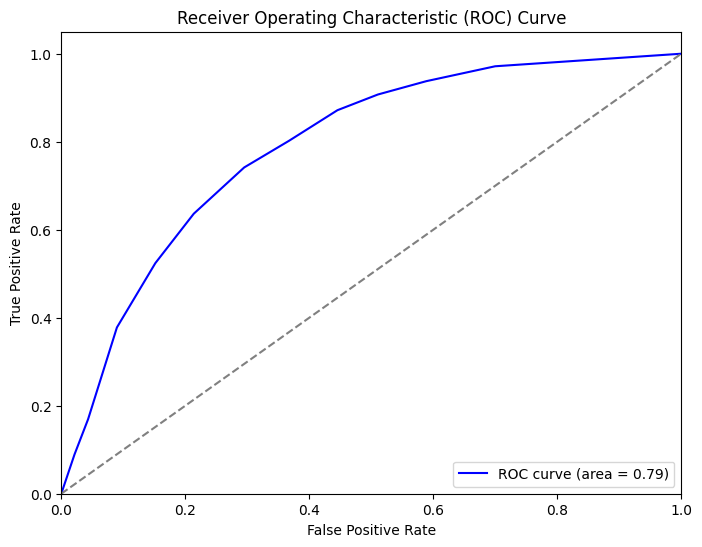

In [24]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_dist = {
    "n_neighbors": [11, 13, 15, 17],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=30, cv=StratifiedKFold(n_splits=15), n_jobs=-1, random_state=42, scoring="recall")
random_search.fit(X_train_res_pca, y_train_res)

best_knn = random_search.best_estimator_

y_pred = best_knn.predict(X_test_pca)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Best Parameters:", random_search.best_params_)
print("=====================================")

y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Hyperparameter tunning jika ingin f1 sebagai acuan

## Bayesian Optimization

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5, 'distance'] before, using random point ['minkowski', 5, 'distance']
  warnings.warn(


Best Parameters: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'uniform')])


Recall: 0.7397504456327986


F1 Score: 0.5853314527503526


Confusion Matrix:
[[1107  442]
 [ 146  415]]


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1549
           1       0.48      0.74      0.59       561

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.69      2110
weighted avg       0.78      0.72      0.74      2110





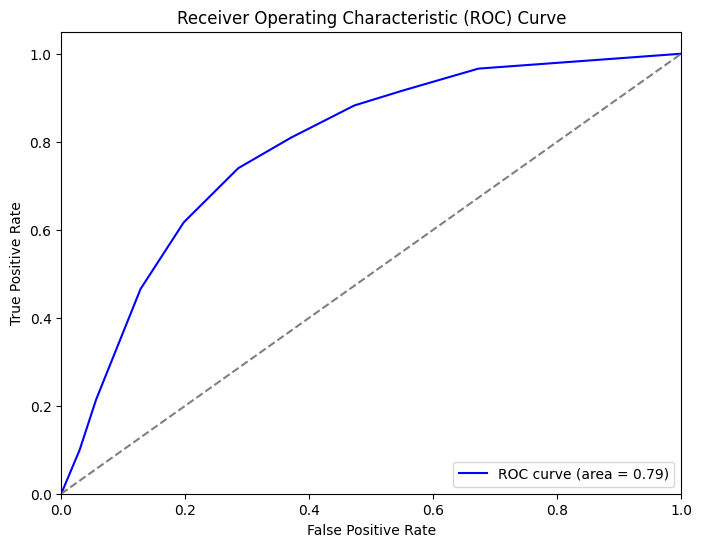

In [25]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_space = {
    "n_neighbors": Categorical([5, 7, 9, 11, 13, 15]),
    "weights": Categorical(["uniform", "distance"]),
    "metric": Categorical(["euclidean", "manhattan", "minkowski"])
}

knn = KNeighborsClassifier()

bayes_search = BayesSearchCV(estimator=knn, search_spaces=param_space, n_iter=30, cv=cv, n_jobs=-1, random_state=42, scoring="f1")
bayes_search.fit(X_train_res_pca, y_train_res)

best_knn = bayes_search.best_estimator_

y_pred = best_knn.predict(X_test_pca)

recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print(f"Best Parameters: {bayes_search.best_params_}")
print("\n")
print(f"Recall: {recall}")
print("\n")
print(f"F1 Score: {f1}")
print("\n")
print(f"Confusion Matrix:\n{conf_matrix}")
print("\n")
print(f"Classification Report:\n{class_report}")
print("\n")

y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Grid Search

Accuracy: 0.7213270142180095
Recall: 0.7397504456327986
F1 Score: 0.5853314527503526
Confusion Matrix:
 [[1107  442]
 [ 146  415]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79      1549
           1       0.48      0.74      0.59       561

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.69      2110
weighted avg       0.78      0.72      0.74      2110

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


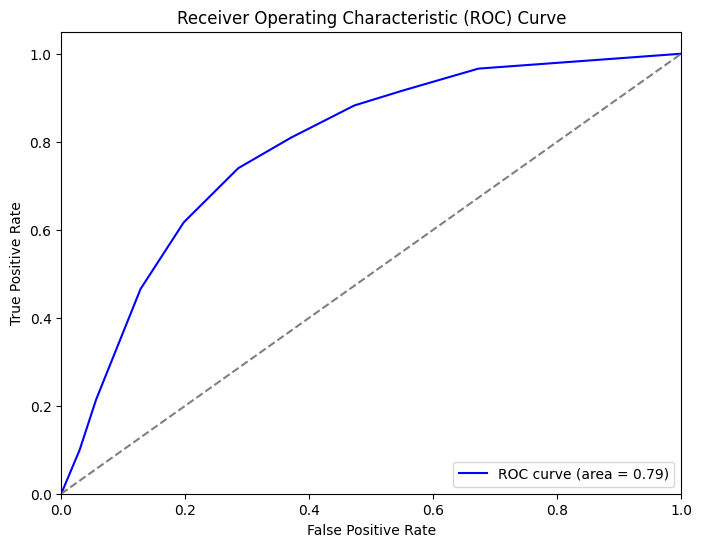

In [26]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_grid = {
    "n_neighbors": [5, 7, 9, 11, 13, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="f1")
grid_search.fit(X_train_res_pca, y_train_res)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_pca)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Best Parameters:", grid_search.best_params_)
print("=====================================")

y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Random search

Accuracy: 0.7213270142180095
Recall: 0.7397504456327986
F1 Score: 0.5853314527503526
Confusion Matrix:
 [[1107  442]
 [ 146  415]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79      1549
           1       0.48      0.74      0.59       561

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.69      2110
weighted avg       0.78      0.72      0.74      2110

Best Parameters: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan'}


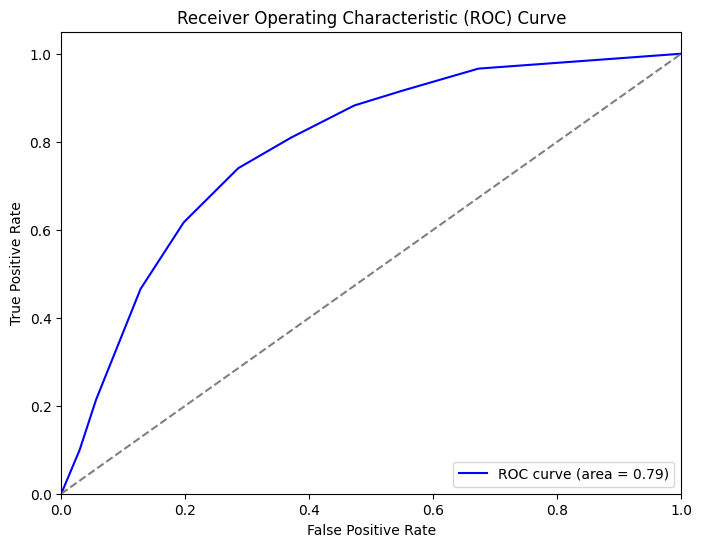

In [27]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_dist = {
    "n_neighbors": [5, 7, 9, 11, 13, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=30, cv=StratifiedKFold(n_splits=15), n_jobs=-1, random_state=42, scoring="f1")
random_search.fit(X_train_res_pca, y_train_res)

best_knn = random_search.best_estimator_

y_pred = best_knn.predict(X_test_pca)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Best Parameters:", random_search.best_params_)
print("=====================================")

# ROC Curve
y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Learning curve calon final model

In [28]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

selector = SelectKBest(score_func=f_classif, k=10)
X_train_res_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_sm)

pca = PCA(n_components=5)
X_train_res_pca = pca.fit_transform(X_train_res_sel)
X_test_pca = pca.transform(X_test_sel)

knn = KNeighborsClassifier(n_neighbors=11, metric="manhattan", weights="uniform")

knn.fit(X_train_res_pca, y_train_res)

y_pred_sm = knn.predict(X_test_pca)

recall = recall_score(y_test_sm, y_pred_sm)
f1 = f1_score(y_test_sm, y_pred_sm)
conf_matrix = confusion_matrix(y_test_sm, y_pred_sm)
class_report = classification_report(y_test_sm, y_pred_sm)

print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Recall Score: 0.7397504456327986
F1 Score: 0.5804195804195804
Confusion Matrix:
[[1095  454]
 [ 146  415]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78      1549
           1       0.48      0.74      0.58       561

    accuracy                           0.72      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.77      0.72      0.73      2110



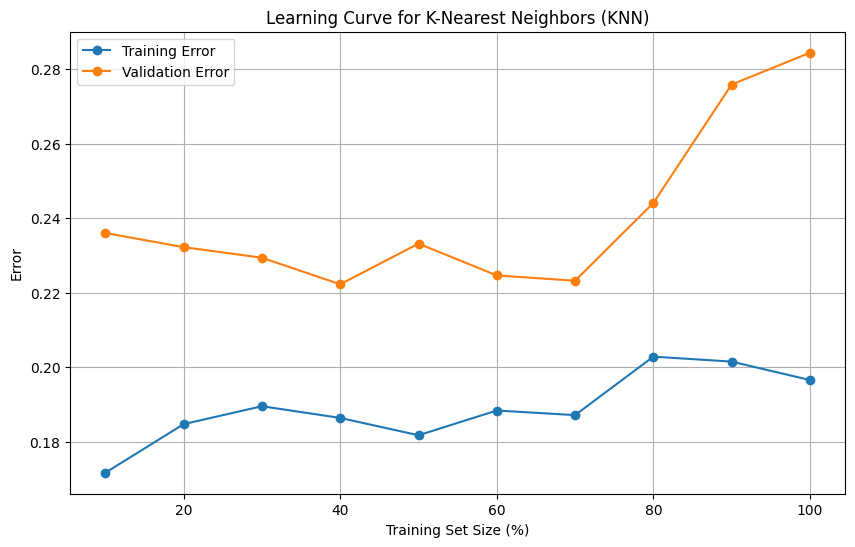

In [29]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for train_size in train_sizes:
    subset_size = int(train_size * len(X_train_res_pca))
    X_train_subset = X_train_res_pca[:subset_size]
    y_train_subset = y_train_res[:subset_size]

    knn = KNeighborsClassifier(n_neighbors=11, metric="manhattan", weights="uniform")
    knn.fit(X_train_subset, y_train_subset)

    y_train_pred = knn.predict(X_train_subset)
    train_error = 1 - accuracy_score(y_train_subset, y_train_pred)
    train_errors.append(train_error)

    y_test_pred = knn.predict(X_test_pca)
    val_error = 1 - accuracy_score(y_test_sm, y_test_pred)
    val_errors.append(val_error)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_errors, label='Training Error', marker='o')
plt.plot(train_sizes * 100, val_errors, label='Validation Error', marker='o')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Error')
plt.title('Learning Curve for K-Nearest Neighbors (KNN)')
plt.legend()
plt.grid()
plt.show()

artinya  dari 11-15 Overfitting jika berdasarkan hyperparameter tunning baik itu dari segi recall ataupun f1

# Cek semua learning curve

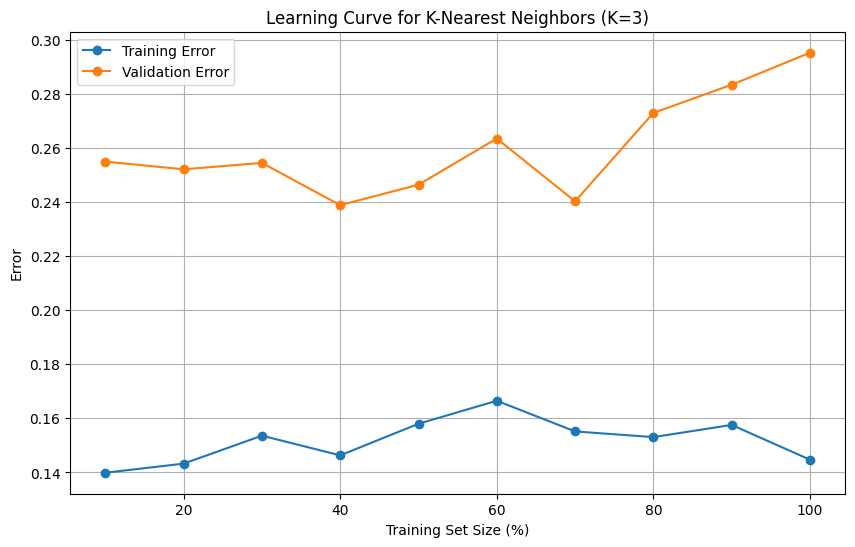

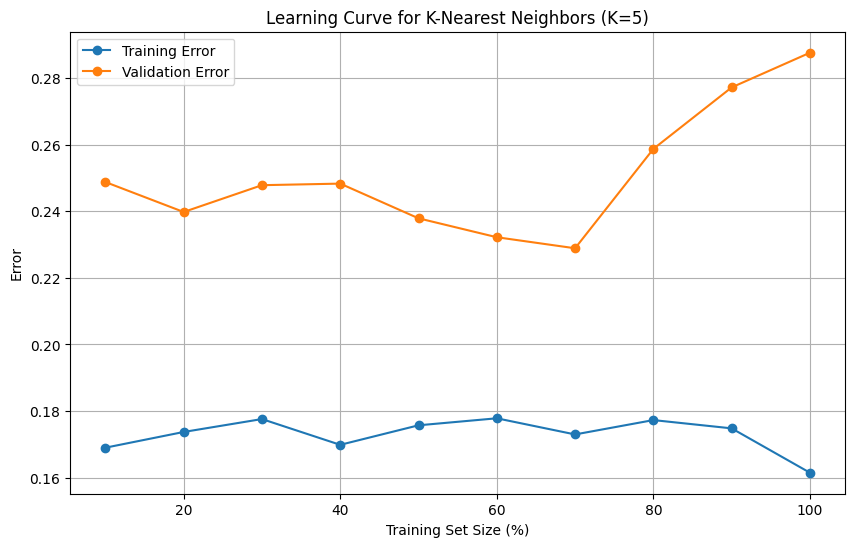

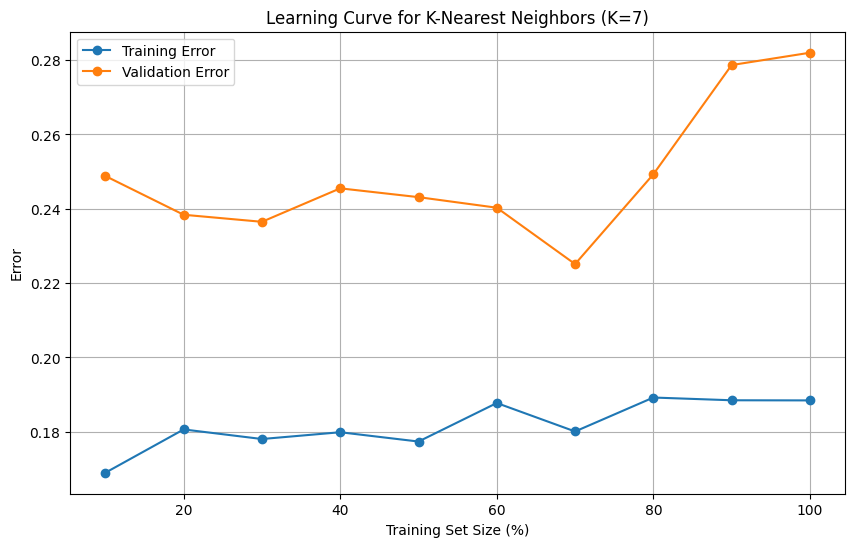

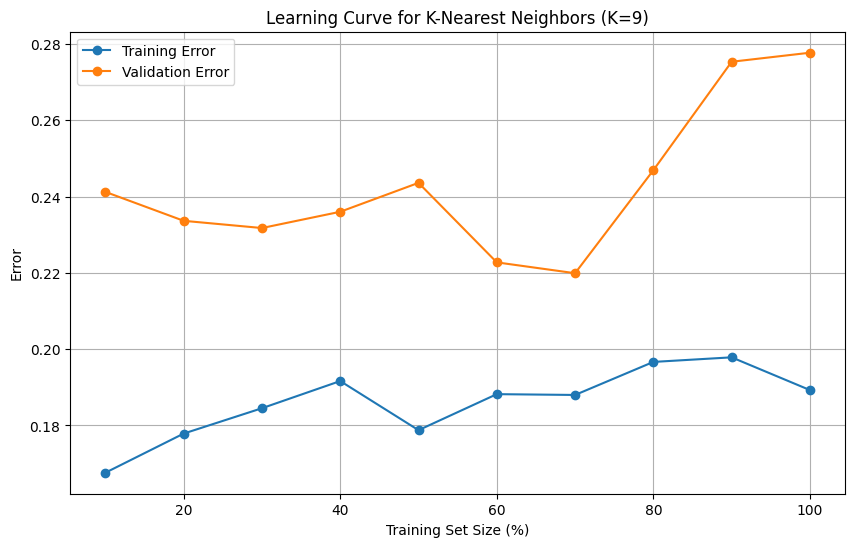

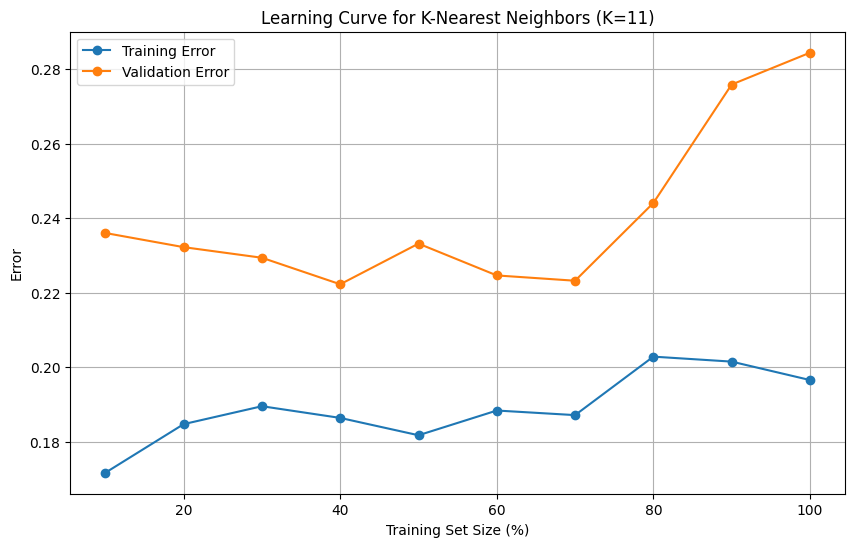

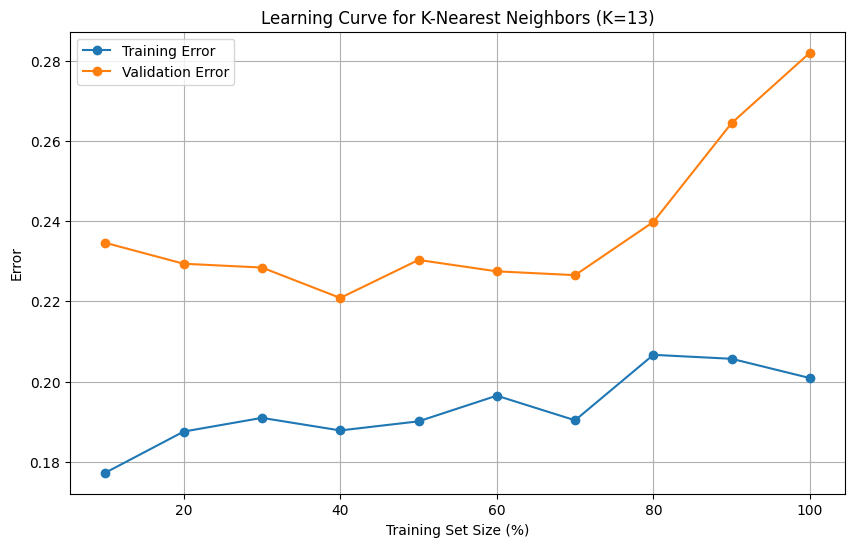

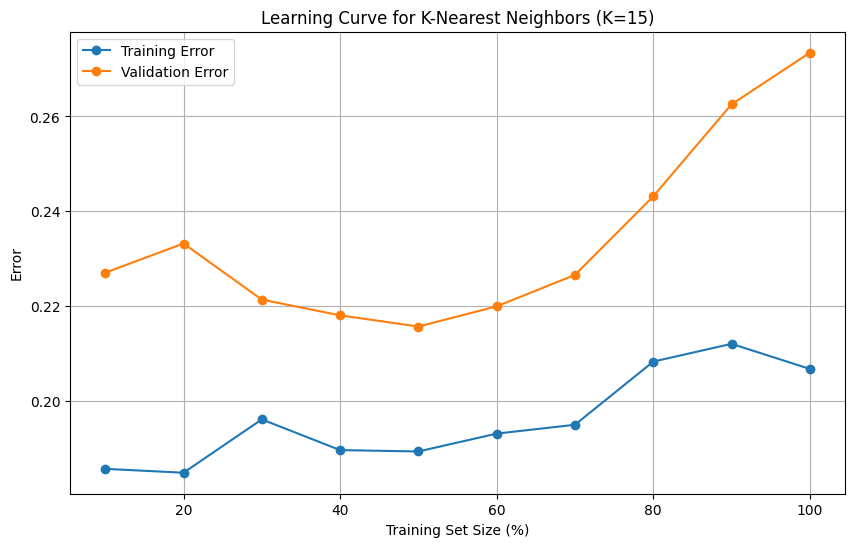

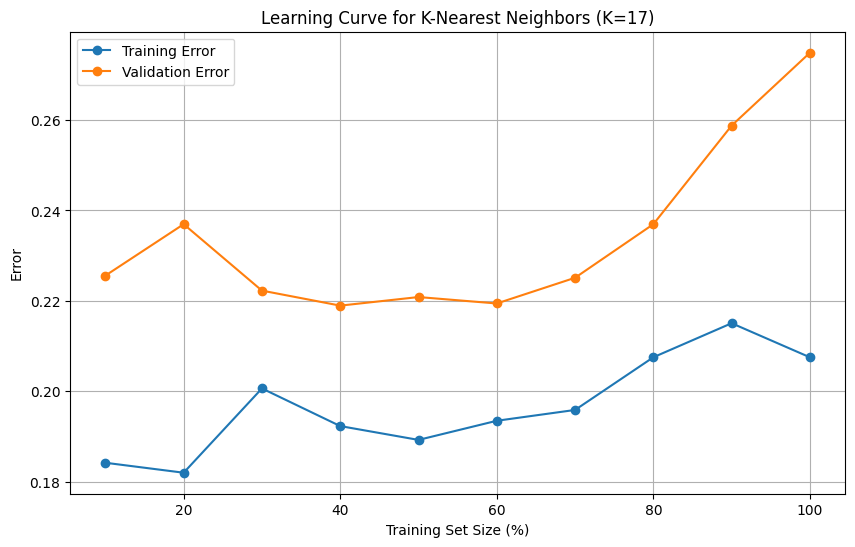

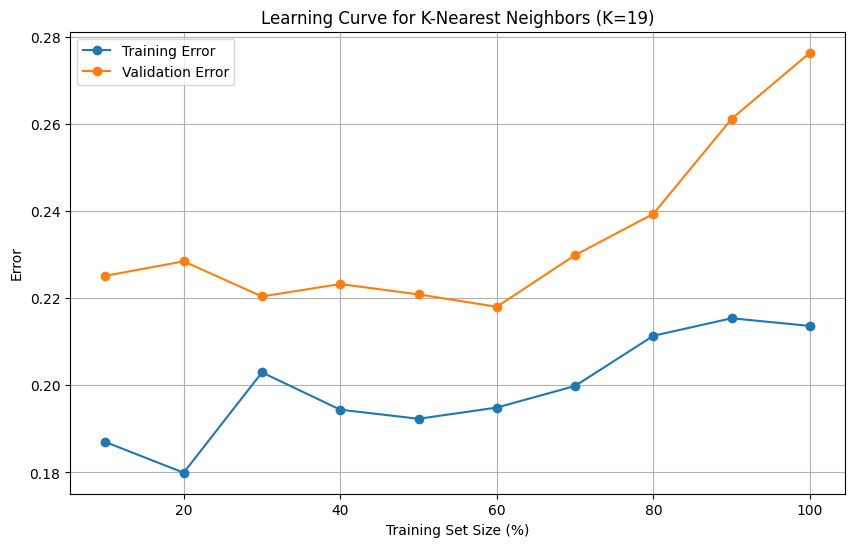

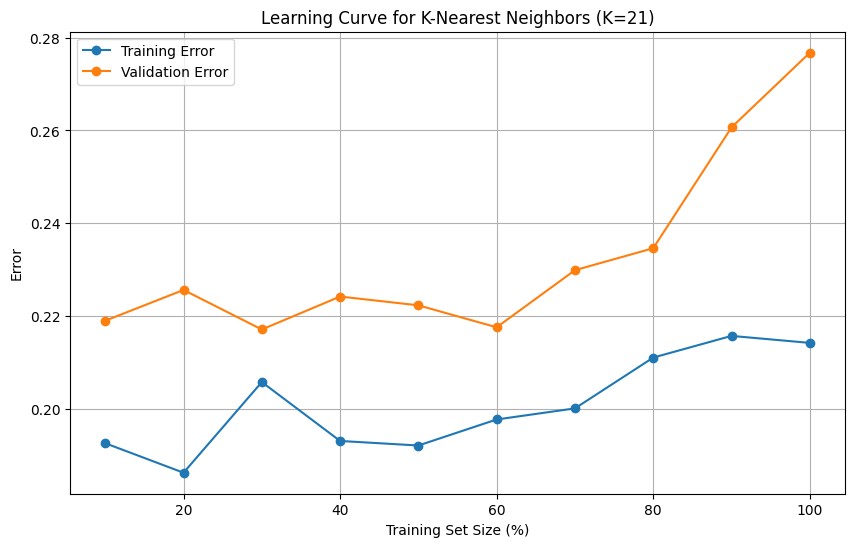

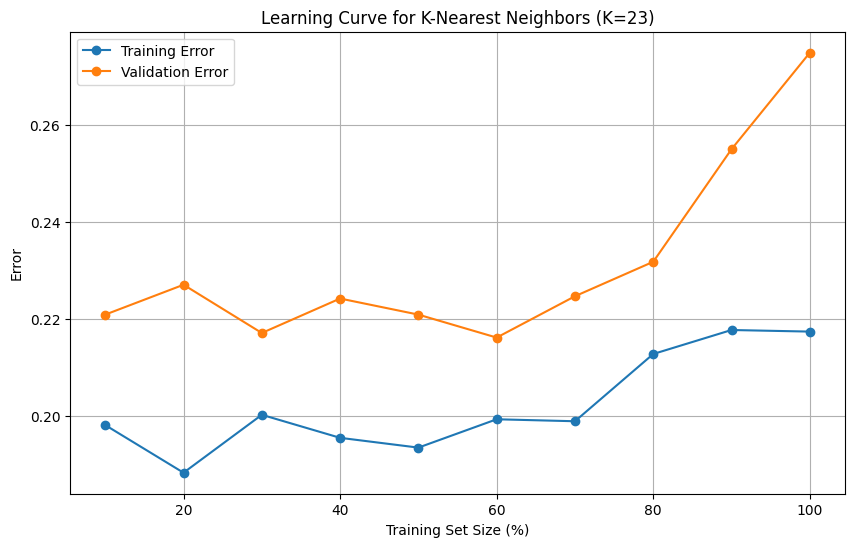

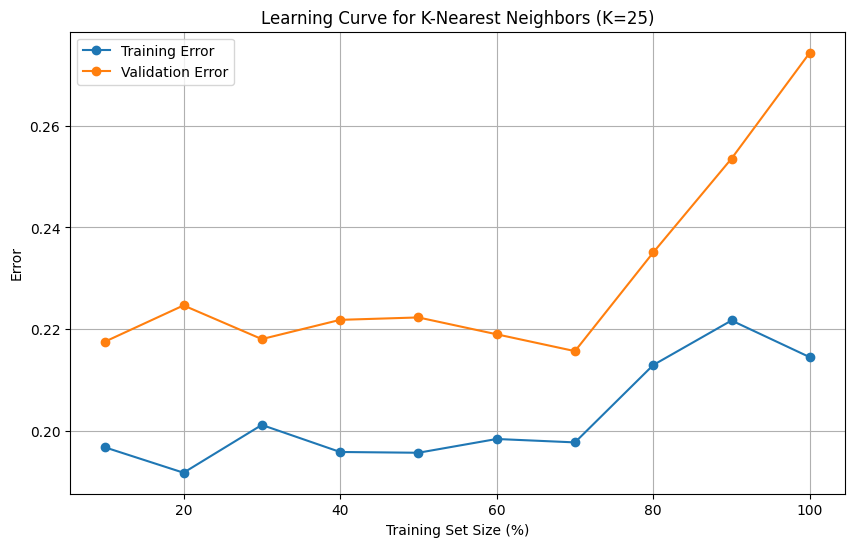

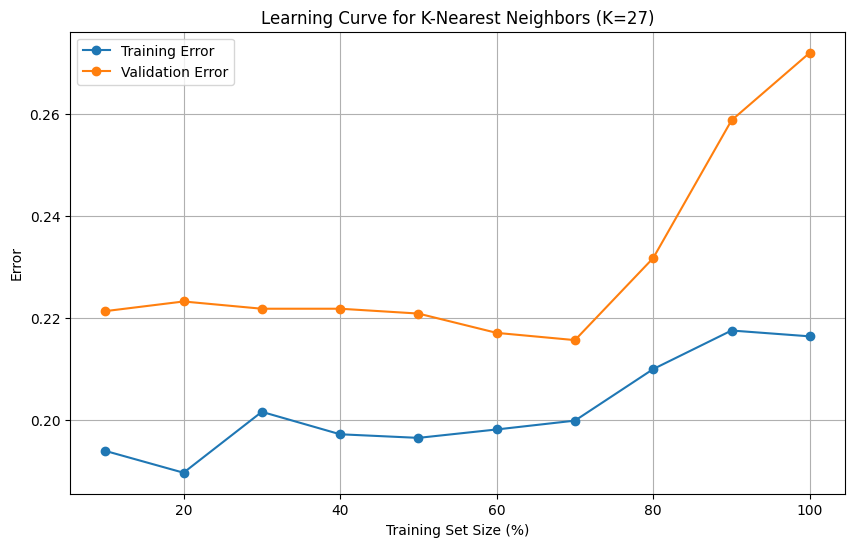

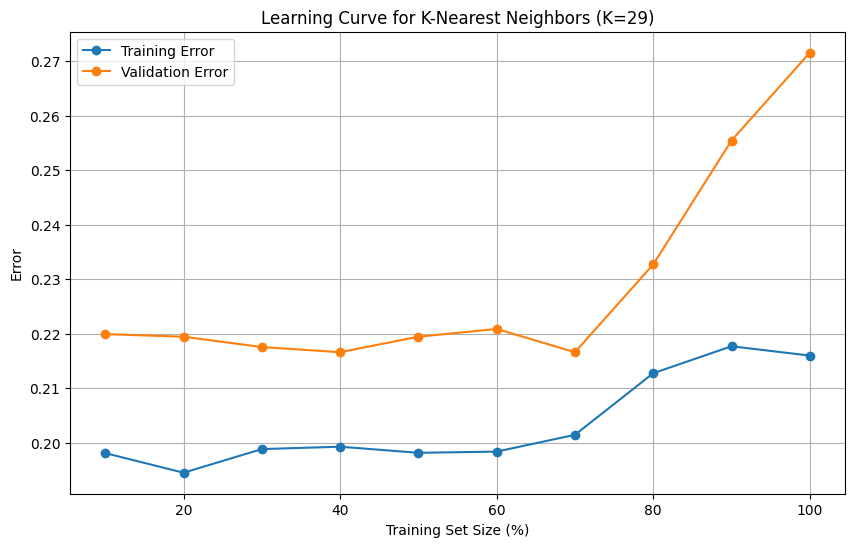

In [30]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

train_sizes = np.linspace(0.1, 1.0, 10)
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

for k in k_values:
    train_errors = []
    val_errors = []
    for train_size in train_sizes:
        subset_size = int(train_size * len(X_train_res_pca))
        X_train_subset = X_train_res_pca[:subset_size]
        y_train_subset = y_train_res[:subset_size]

        knn = KNeighborsClassifier(n_neighbors=k, metric="manhattan", weights="uniform")
        knn.fit(X_train_subset, y_train_subset)

        y_train_pred = knn.predict(X_train_subset)
        train_error = 1 - accuracy_score(y_train_subset, y_train_pred)
        train_errors.append(train_error)

        y_test_pred = knn.predict(X_test_pca)
        val_error = 1 - accuracy_score(y_test_sm, y_test_pred)
        val_errors.append(val_error)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * 100, train_errors, label='Training Error', marker='o')
    plt.plot(train_sizes * 100, val_errors, label='Validation Error', marker='o')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('Error')
    plt.title(f'Learning Curve for K-Nearest Neighbors (K={k})')
    plt.legend()
    plt.grid()
    plt.show()

model ini tidak bisa dilanjutkan lagi karena semuanya overfitting